In [1]:
import pandas as pd
import numpy as np
from numpy.lib.function_base import average
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
import folium
from folium import plugins
from IPython.display import Image
import branca.colormap as cm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Modelling Libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Evaluation & CV Libraries
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
import optuna

In [2]:
df=pd.read_csv('kc_house_data.csv')
df.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1075,6099400030,20150114T000000,320000.0,3,1.75,2300,41900,1.0,0,0,...,8,1310,990,1939,0,98168,47.4770,-122.292,1160,8547
8163,1724069079,20150319T000000,1452000.0,2,3.25,2070,3128,2.0,1,3,...,9,1760,310,1988,0,98075,47.5686,-122.060,2740,3568
21248,2911700010,20150303T000000,1080000.0,3,2.50,2240,21477,2.0,0,2,...,8,2240,0,1995,0,98006,47.5745,-122.180,2930,21569
11497,3260200200,20141030T000000,580000.0,3,2.25,1670,7416,1.0,0,0,...,7,1220,450,1974,0,98005,47.6028,-122.172,1710,7416
16171,8081900101,20140528T000000,960000.0,4,2.25,2410,4560,2.0,0,2,...,9,1800,610,1929,0,98117,47.6796,-122.402,2150,5100
14816,1525059261,20150505T000000,1900000.0,5,4.50,5160,44315,2.0,0,0,...,12,5160,0,1996,0,98005,47.6568,-122.154,4760,44315
20707,603000926,20140522T000000,380000.0,5,3.50,2420,4670,2.0,0,0,...,7,2420,0,2013,0,98118,47.5241,-122.285,1430,4468
19026,9276200455,20141121T000000,724950.0,4,2.00,2270,5760,2.0,0,0,...,8,2270,0,1909,0,98116,47.5809,-122.390,1420,5760
11617,7864500140,20141107T000000,275000.0,4,1.50,1610,6923,1.0,0,0,...,6,1010,600,1969,0,98198,47.3747,-122.306,1320,7684
10254,2422049104,20141230T000000,235000.0,2,1.00,830,9000,1.0,0,0,...,6,830,0,1939,0,98032,47.3813,-122.243,1160,7680


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

### A data set contains 21613 obervations with 19 features plus house price. The names of the columns are given below.

    # id - Unique ID for each home sold
    # date - Date of the home sale
    # price - Price of each home sold
    # bedrooms - Number of bedrooms
    # bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
    # sqft_living - Square footage of the apartments interior living space
    # sqft_lot - Square footage of the land space
    # floors - Number of floors
    # waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
    # view - An index from 0 to 4 of how good the view of the property was 0 = No view, 1 = Fair 2 = Average, 3 = Good, 4 = Excellent
    # condition - An index from 1 to 5 on the condition of the apartment,1 = Poor- Worn out, 2 = Fair- Badly worn, 3 = Average, 4 = Good, 5= Very Good
    # grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
    # sqft_above - The square footage of the interior housing space that is above ground level
    # sqft_basement - The square footage of the interior housing space that is below ground level
    # yr_built - The year the house was initially built
    # yr_renovated - The year of the house’s last renovation
    # zipcode - What zipcode area the house is in
    # lat - Lattitude
    # long - Longitude
    # sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
    # sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21613.0,3.370842e+00,9.300618e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.114757e+00,7.701632e-01,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184409e+02,2.900000e+02,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.494309e+00,5.399889e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,7.541757e-03,8.651720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.343034e-01,7.663176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.409430e+00,6.507430e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


     It looks like there are few columns were are more than 75% of zeros ('waterfront', 'view', 'yr_renovated')

In [5]:
# Create a summary dictionary
summary_data = {
    'Column': ['waterfront', 'view', 'yr_renovated'],
    'Total Zeros': [df['waterfront'].eq(0).sum(), df['view'].eq(0).sum(), df['yr_renovated'].eq(0).sum()],
    'Total Entries': [len(df)] * 3
}

# Create a summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Calculate the percentage of zeros and add it to the DataFrame
summary_df['Percentage Zeros'] = (summary_df['Total Zeros'] / summary_df['Total Entries']) * 100

# Print the sorted summary DataFrame
summary_df.sort_values(by="Total Zeros" , ascending=False)

,Column,Total Zeros,Total Entries,Percentage Zeros
0,waterfront,21450,21613,99.245824
2,yr_renovated,20699,21613,95.771064
1,view,19489,21613,90.172581


In [6]:
# > 95% of records are zeros, I'll drop those columns:
df.drop(columns=['waterfront', 'yr_renovated'], axis=1, inplace=True)

# Data cleaning

In [7]:
# 'id' is a feature with unique id for each house sales, I'll drop it:
df.drop(['id'], axis=1, inplace=True)

In [8]:
df['date']=pd.to_datetime(df['date'])

In [9]:
start_date = df['date'].min()
end_date = df['date'].max()

message = f"House sales were between {start_date} and {end_date}"
print(message)

House sales were between 2014-05-02 00:00:00 and 2015-05-27 00:00:00


In [10]:
# I'll drop column 'date':
df.drop('date', axis=1, inplace=True)

# Exploratory Data Analysis

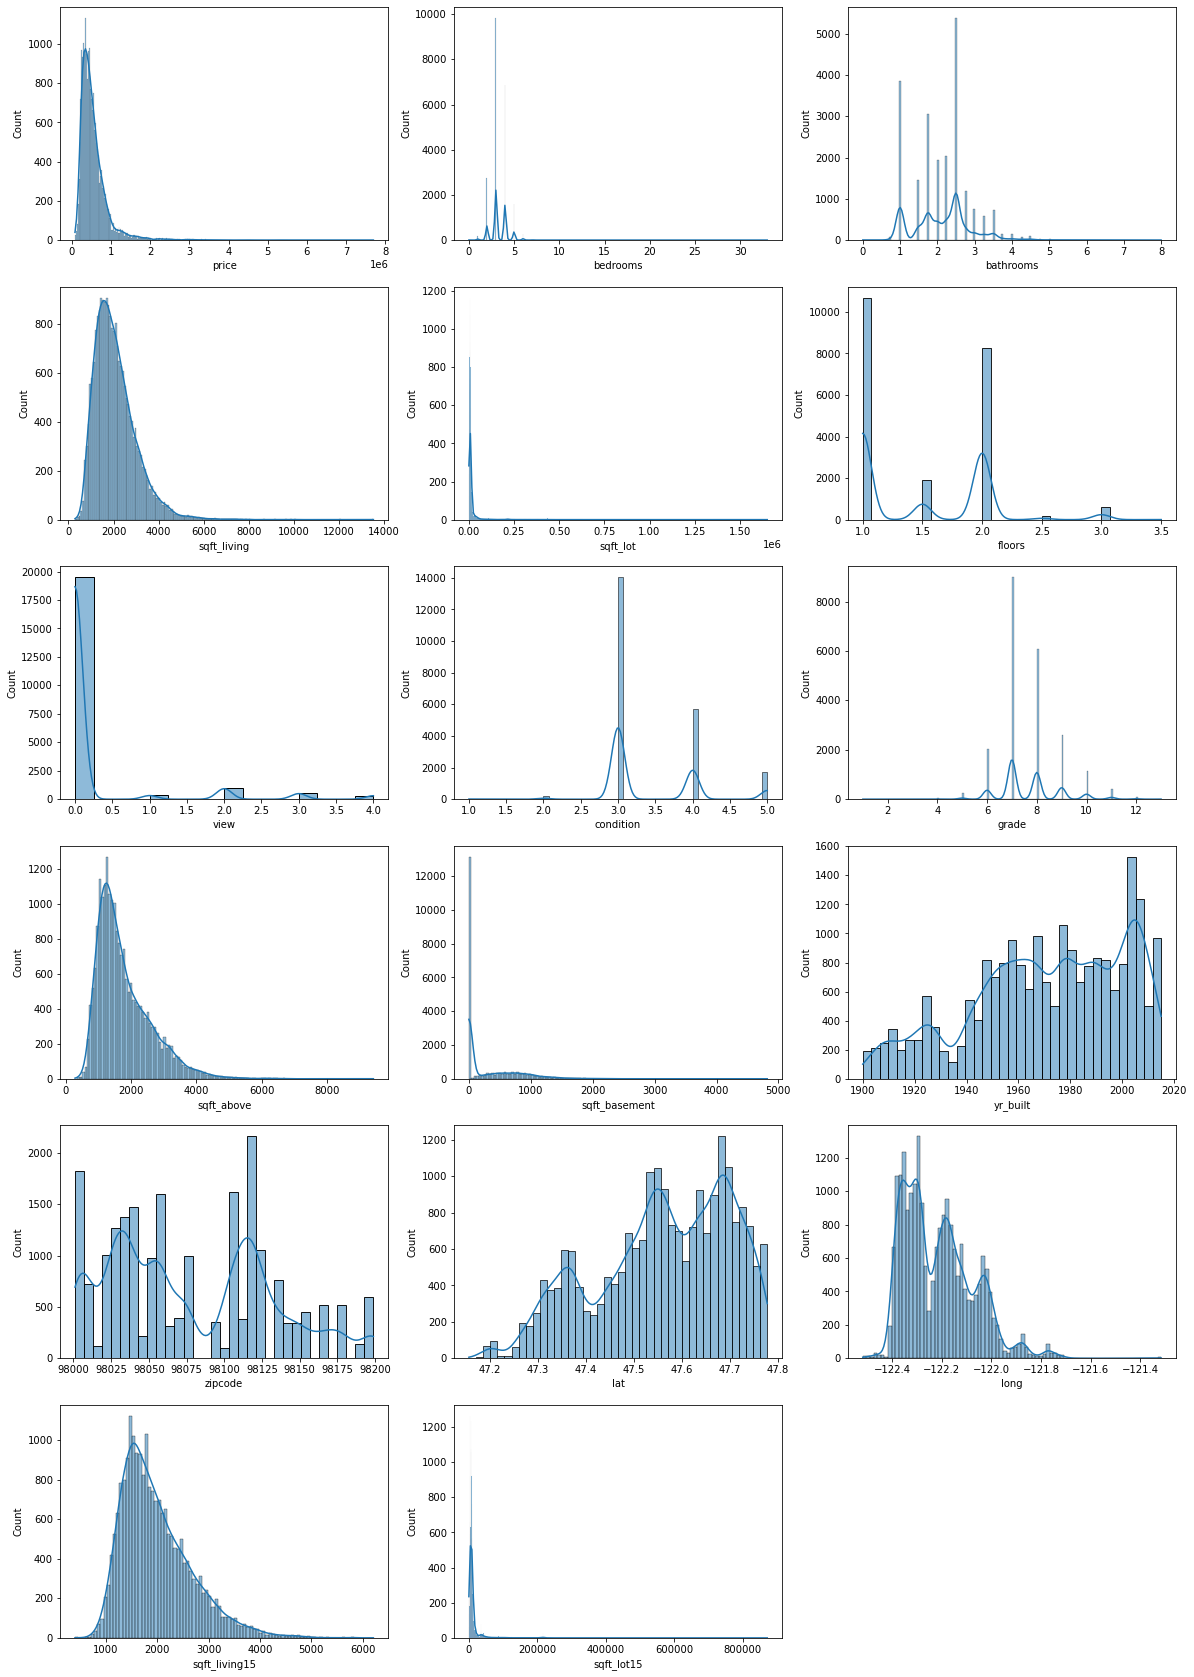

In [11]:
# Let's check the distributions of our features

plt.figure(figsize=(20,30))

for i, col in enumerate(df.columns):
        ax = plt.subplot(6, 3, i+1)
        sns.histplot(df[col] , ax=ax , kde=True)
        plt.xlabel(col)

plt.show()

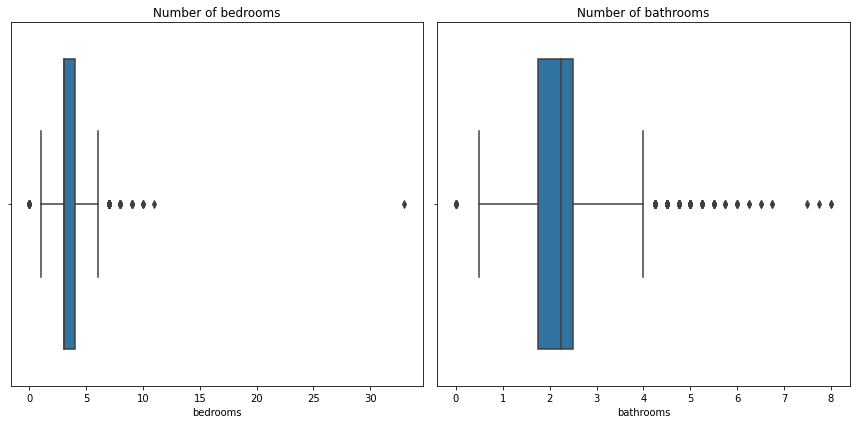

In [12]:
# Bedrooms and bathrooms
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Draw the boxplot for 'bedrooms'
sns.boxplot(data=df, x='bedrooms', whis=2, ax=axes[0])
axes[0].set_title('Number of bedrooms')

# Draw the boxplot for 'bathrooms'
sns.boxplot(data=df, x='bathrooms', whis=2, ax=axes[1])
axes[1].set_title('Number of bathrooms')

# Adjust layout
plt.tight_layout()

# Show the boxplots
plt.show()

    There are houses without bedrooms or bathrooms? I hope this is mistake.

In [13]:
# I'll remove outliers from those two columns
def remove_outliers(column, threshold=2):
    z_scores = np.abs((column - column.mean()) / column.std())
    return column.where(z_scores < threshold)

df['bathrooms'] = remove_outliers(df['bathrooms'])
df['bedrooms'] = remove_outliers(df['bedrooms'])

In [14]:
# impute missing values with KNNImputer
imputer = KNNImputer()
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns=df.columns)

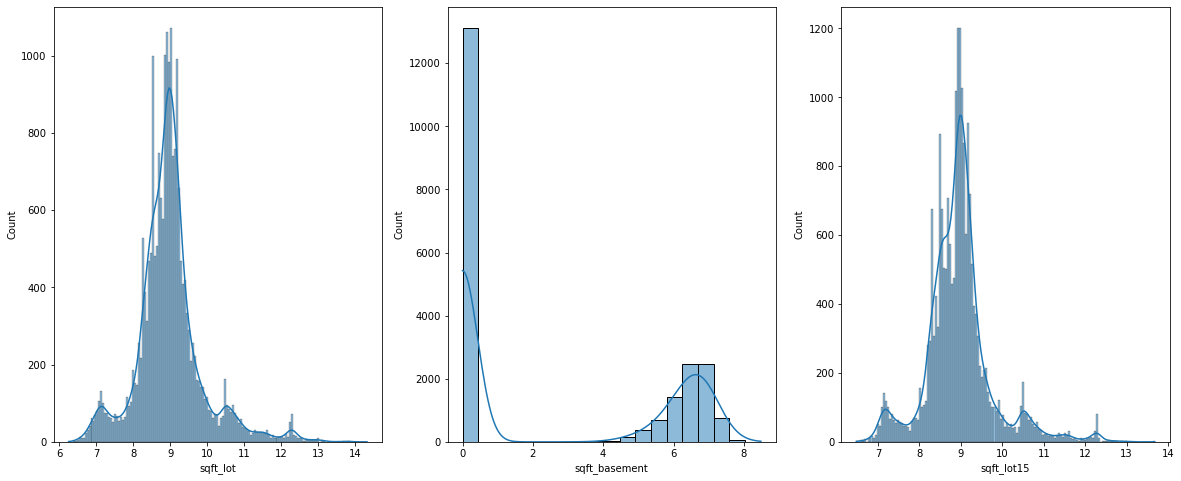

In [15]:
# Applying Log Transformation to handle the Skewness in our features

Skewed_Columns = ['sqft_lot', 'sqft_basement', 'sqft_lot15']

for col in Skewed_Columns:
    df[col] = np.log(1 + df[col])

# Let's check the distributions of skewed features after Log Transformation

plt.figure(figsize=(20,8))

for i, col in enumerate(df[Skewed_Columns]):

        ax = plt.subplot(1, 3, i+1)
        sns.histplot(df[col] , ax=ax , kde=True)
        plt.xlabel(col)

plt.show()

In [16]:
# create a new map object
m = folium.Map(location=[47.525,-121.95], zoom_start=10)

location=df[["lat","long"]]

folium.plugins.MarkerCluster(location).add_to(m)

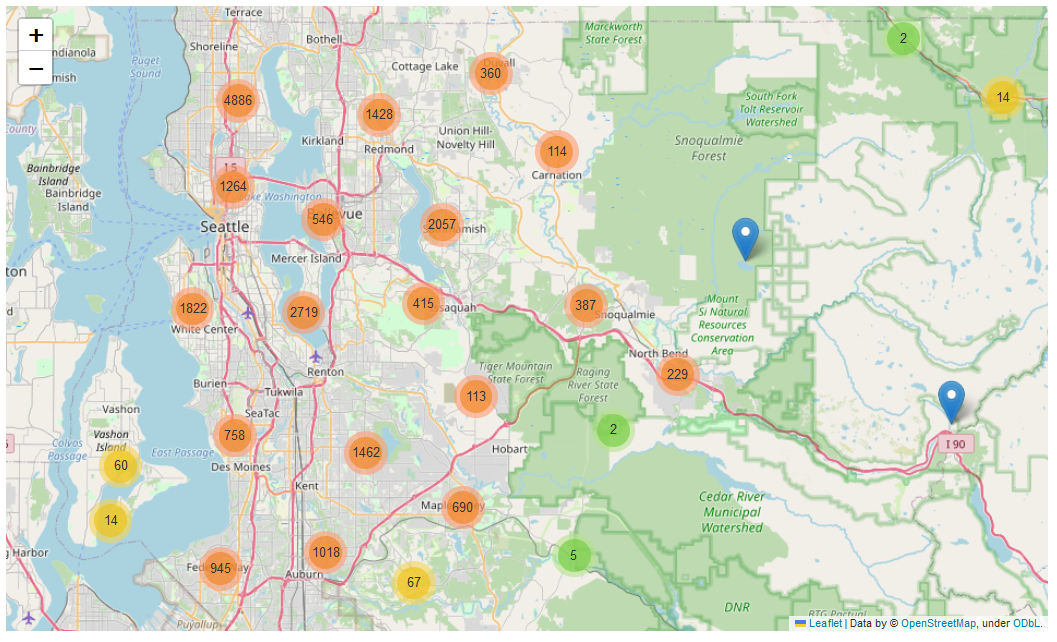

In [16]:
Image(filename='output.png')

In [8]:
# create a LinearColorMap and assign colors
colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=0, vmax=2000000)

m = folium.Map(location=[47.525,-121.95], zoom_start=10)

# This time I add a color using price and the colormap object
for i in range(len(df)):
    folium.Circle(
        location=[df.iloc[i]['lat'], df.iloc[i]['long']],
        radius=8,
        fill=True,
        color=colormap(df.iloc[i]['price']),
        fill_opacity=0.2
    ).add_to(m)

# m.add_child(colormap)

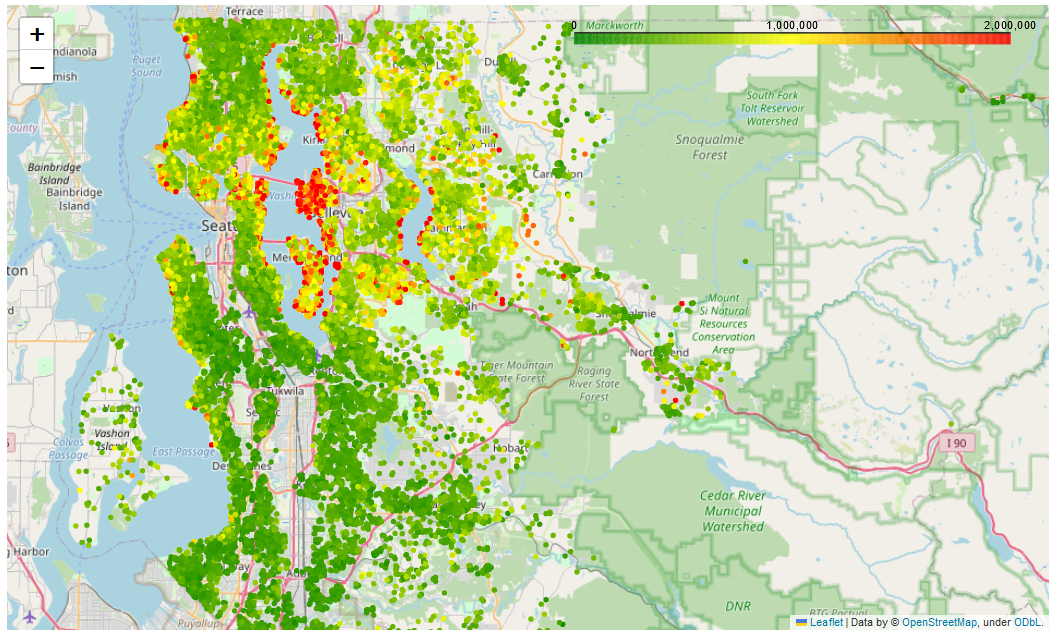

In [17]:
Image(filename='price_colormap.png')

    The highest prices are shown in red. We can see that in one place there is many such apartments.

In [17]:
# Zipcode - I'll use this column to calculate average home prices

# Calculate the mean price grouped by 'zipcode'
zipcode_means = df.groupby('zipcode')['price'].mean()

# Create a new column 'home_location_value' based on the 'zipcode' means
df['home_location_value'] = df['zipcode'].map(zipcode_means)

df['zipcode'] = df['zipcode'].astype(int)

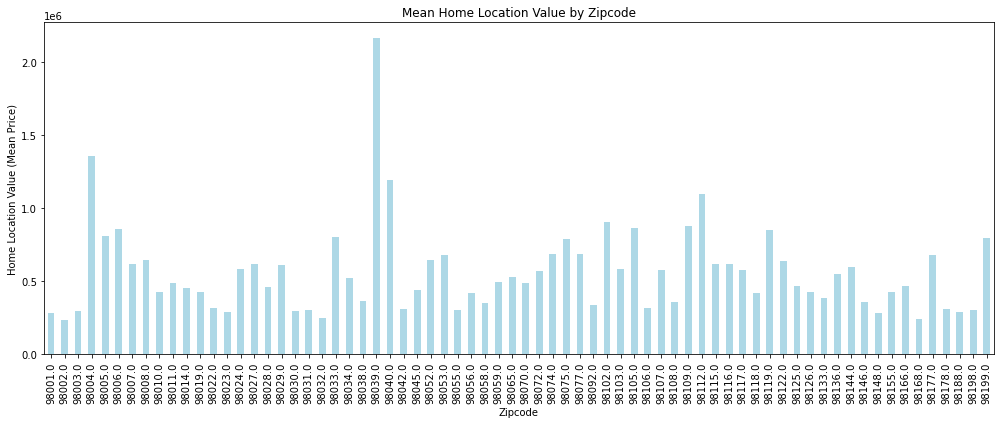

In [18]:
# Create a bar plot
plt.figure(figsize=(14, 6))
zipcode_means.plot(kind='bar', color='lightblue')
plt.xlabel('Zipcode')
plt.ylabel('Home Location Value (Mean Price)')
plt.title('Mean Home Location Value by Zipcode')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                21613 non-null  float64
 1   bedrooms             21613 non-null  float64
 2   bathrooms            21613 non-null  float64
 3   sqft_living          21613 non-null  float64
 4   sqft_lot             21613 non-null  float64
 5   floors               21613 non-null  float64
 6   view                 21613 non-null  float64
 7   condition            21613 non-null  float64
 8   grade                21613 non-null  float64
 9   sqft_above           21613 non-null  float64
 10  sqft_basement        21613 non-null  float64
 11  yr_built             21613 non-null  float64
 12  zipcode              21613 non-null  int32  
 13  lat                  21613 non-null  float64
 14  long                 21613 non-null  float64
 15  sqft_living15        21613 non-null 

In [20]:
# Drop uncessary column
df.drop(['zipcode', 'lat', 'long'], axis=1, inplace=True)

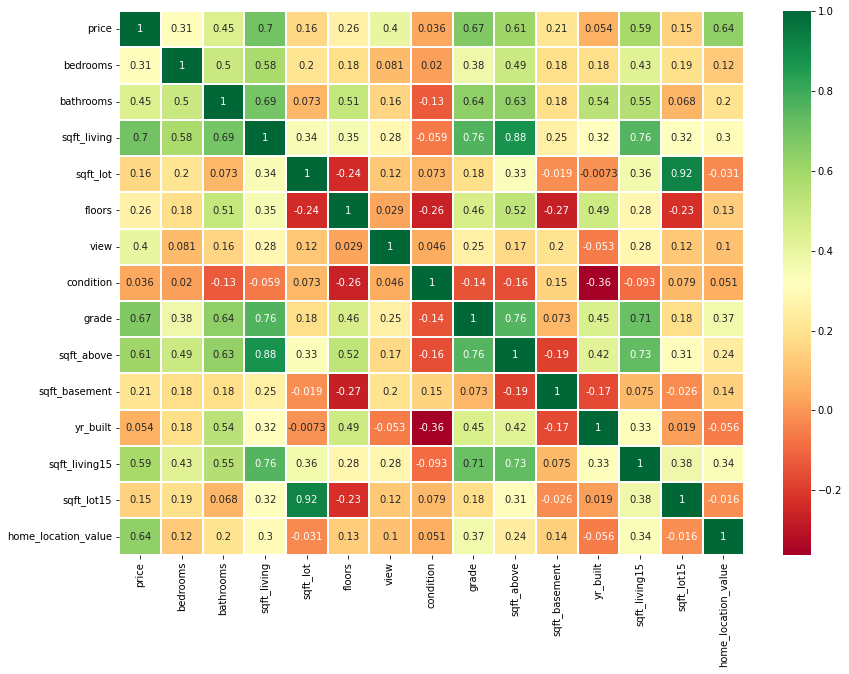

In [21]:
# Checking the correlation
corr=df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)
plt.show()

# 2 Standardization

In [22]:
# Defining target (y) and variables (X) 
X = df.drop(columns=['price'])
y = df['price']

# Create train and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#  Models

In [24]:
models =[('RF',RandomForestRegressor(random_state=42)), ("CTB", CatBoostRegressor(random_state=42)),
         ("LGBM",LGBMRegressor(random_state=42)), ('GBR',GradientBoostingRegressor(random_state=42)),
         ('XGB', XGBRegressor(random_state=42))]

In [25]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = []
    for name, model in models:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        results.append({
            'Model': name,
            'Train R2 Score': train_r2,
            'Test R2 Score': test_r2,
            'Train MAE': train_mae,
            'Test MAE': test_mae
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [32]:
results_df = evaluate_models(models, X_train, X_test, y_train, y_test)

Learning rate set to 0.064232
0:	learn: 345867.7963101	total: 5.63ms	remaining: 5.62s
1:	learn: 332069.4978981	total: 11ms	remaining: 5.49s
2:	learn: 318632.2640558	total: 16.2ms	remaining: 5.38s
3:	learn: 306141.0586300	total: 21.3ms	remaining: 5.31s
4:	learn: 294978.5472596	total: 25.8ms	remaining: 5.13s
5:	learn: 284639.8209652	total: 30.1ms	remaining: 4.99s
6:	learn: 274743.8242065	total: 34.2ms	remaining: 4.84s
7:	learn: 265580.0780547	total: 37.6ms	remaining: 4.66s
8:	learn: 256563.0723463	total: 40.5ms	remaining: 4.46s
9:	learn: 248120.8914028	total: 43.5ms	remaining: 4.3s
10:	learn: 240599.2967064	total: 46.6ms	remaining: 4.19s
11:	learn: 233429.9205670	total: 49.5ms	remaining: 4.07s
12:	learn: 226870.8432018	total: 52.8ms	remaining: 4.01s
13:	learn: 220551.0600188	total: 55.9ms	remaining: 3.94s
14:	learn: 214922.1586588	total: 59.1ms	remaining: 3.88s
15:	learn: 209654.5835542	total: 62.2ms	remaining: 3.82s
16:	learn: 204952.8492247	total: 65.2ms	remaining: 3.77s
17:	learn: 200

166:	learn: 112523.1336017	total: 704ms	remaining: 3.51s
167:	learn: 112425.1379064	total: 708ms	remaining: 3.5s
168:	learn: 112267.5128004	total: 711ms	remaining: 3.5s
169:	learn: 112107.3938806	total: 715ms	remaining: 3.49s
170:	learn: 111999.7742358	total: 719ms	remaining: 3.49s
171:	learn: 111877.2639000	total: 723ms	remaining: 3.48s
172:	learn: 111768.1736188	total: 727ms	remaining: 3.48s
173:	learn: 111677.3989077	total: 732ms	remaining: 3.47s
174:	learn: 111531.6632374	total: 735ms	remaining: 3.46s
175:	learn: 111453.5707288	total: 739ms	remaining: 3.46s
176:	learn: 111303.6059137	total: 743ms	remaining: 3.45s
177:	learn: 111202.6341414	total: 746ms	remaining: 3.44s
178:	learn: 111061.2069833	total: 749ms	remaining: 3.44s
179:	learn: 110868.6847081	total: 755ms	remaining: 3.44s
180:	learn: 110759.5993017	total: 759ms	remaining: 3.44s
181:	learn: 110639.1556999	total: 763ms	remaining: 3.43s
182:	learn: 110509.2627079	total: 768ms	remaining: 3.43s
183:	learn: 110415.5173537	total:

328:	learn: 98423.3653034	total: 1.24s	remaining: 2.52s
329:	learn: 98351.3640724	total: 1.24s	remaining: 2.52s
330:	learn: 98270.2572780	total: 1.24s	remaining: 2.52s
331:	learn: 98209.5917475	total: 1.25s	remaining: 2.51s
332:	learn: 98145.3072257	total: 1.25s	remaining: 2.51s
333:	learn: 98073.5122446	total: 1.25s	remaining: 2.5s
334:	learn: 97999.7039652	total: 1.26s	remaining: 2.5s
335:	learn: 97947.8419742	total: 1.26s	remaining: 2.5s
336:	learn: 97915.5466460	total: 1.26s	remaining: 2.49s
337:	learn: 97847.3316735	total: 1.27s	remaining: 2.48s
338:	learn: 97795.2912947	total: 1.27s	remaining: 2.48s
339:	learn: 97756.5334909	total: 1.28s	remaining: 2.48s
340:	learn: 97707.5988286	total: 1.28s	remaining: 2.47s
341:	learn: 97643.4174499	total: 1.28s	remaining: 2.47s
342:	learn: 97570.8017803	total: 1.28s	remaining: 2.46s
343:	learn: 97505.4191501	total: 1.29s	remaining: 2.46s
344:	learn: 97466.5112708	total: 1.29s	remaining: 2.45s
345:	learn: 97418.1160246	total: 1.29s	remaining: 2

475:	learn: 91269.8383195	total: 1.76s	remaining: 1.94s
476:	learn: 91238.1640768	total: 1.76s	remaining: 1.94s
477:	learn: 91201.8870726	total: 1.77s	remaining: 1.93s
478:	learn: 91183.0141125	total: 1.77s	remaining: 1.93s
479:	learn: 91138.5219613	total: 1.78s	remaining: 1.93s
480:	learn: 91116.8708628	total: 1.78s	remaining: 1.92s
481:	learn: 91071.7646449	total: 1.78s	remaining: 1.92s
482:	learn: 91034.9828236	total: 1.79s	remaining: 1.92s
483:	learn: 90982.0015528	total: 1.79s	remaining: 1.91s
484:	learn: 90957.7995656	total: 1.79s	remaining: 1.91s
485:	learn: 90924.7213036	total: 1.8s	remaining: 1.9s
486:	learn: 90891.4492343	total: 1.8s	remaining: 1.9s
487:	learn: 90867.5989987	total: 1.81s	remaining: 1.9s
488:	learn: 90836.9205113	total: 1.81s	remaining: 1.89s
489:	learn: 90798.8685805	total: 1.81s	remaining: 1.89s
490:	learn: 90756.3845373	total: 1.82s	remaining: 1.89s
491:	learn: 90702.1105501	total: 1.82s	remaining: 1.88s
492:	learn: 90658.2683723	total: 1.83s	remaining: 1.8

659:	learn: 85046.9807570	total: 2.47s	remaining: 1.27s
660:	learn: 85027.5255530	total: 2.48s	remaining: 1.27s
661:	learn: 85001.4348013	total: 2.48s	remaining: 1.27s
662:	learn: 84977.4930714	total: 2.49s	remaining: 1.26s
663:	learn: 84948.5556528	total: 2.49s	remaining: 1.26s
664:	learn: 84923.0582935	total: 2.5s	remaining: 1.26s
665:	learn: 84895.4405049	total: 2.5s	remaining: 1.25s
666:	learn: 84868.8691899	total: 2.51s	remaining: 1.25s
667:	learn: 84845.8927705	total: 2.52s	remaining: 1.25s
668:	learn: 84818.0265927	total: 2.52s	remaining: 1.25s
669:	learn: 84773.5314855	total: 2.52s	remaining: 1.24s
670:	learn: 84739.7551261	total: 2.53s	remaining: 1.24s
671:	learn: 84717.6926498	total: 2.54s	remaining: 1.24s
672:	learn: 84698.9782604	total: 2.54s	remaining: 1.24s
673:	learn: 84668.7281200	total: 2.55s	remaining: 1.23s
674:	learn: 84638.5234322	total: 2.55s	remaining: 1.23s
675:	learn: 84615.1754608	total: 2.56s	remaining: 1.23s
676:	learn: 84592.4925405	total: 2.56s	remaining: 

830:	learn: 80574.4909622	total: 3.18s	remaining: 646ms
831:	learn: 80523.5723626	total: 3.18s	remaining: 643ms
832:	learn: 80494.4678419	total: 3.19s	remaining: 639ms
833:	learn: 80459.2192909	total: 3.19s	remaining: 635ms
834:	learn: 80441.4338548	total: 3.19s	remaining: 631ms
835:	learn: 80401.6740931	total: 3.19s	remaining: 627ms
836:	learn: 80384.4172140	total: 3.2s	remaining: 623ms
837:	learn: 80354.1062731	total: 3.2s	remaining: 619ms
838:	learn: 80331.0954170	total: 3.21s	remaining: 615ms
839:	learn: 80304.9353724	total: 3.21s	remaining: 611ms
840:	learn: 80289.1544327	total: 3.21s	remaining: 607ms
841:	learn: 80249.9853228	total: 3.21s	remaining: 603ms
842:	learn: 80235.3853469	total: 3.22s	remaining: 599ms
843:	learn: 80204.3733366	total: 3.22s	remaining: 595ms
844:	learn: 80184.4020492	total: 3.22s	remaining: 591ms
845:	learn: 80159.6469679	total: 3.23s	remaining: 588ms
846:	learn: 80141.1341085	total: 3.23s	remaining: 584ms
847:	learn: 80112.5340399	total: 3.23s	remaining: 

988:	learn: 77095.5842519	total: 3.71s	remaining: 41.3ms
989:	learn: 77082.7666480	total: 3.71s	remaining: 37.5ms
990:	learn: 77070.4775228	total: 3.72s	remaining: 33.8ms
991:	learn: 77046.1670785	total: 3.72s	remaining: 30ms
992:	learn: 77021.6340443	total: 3.73s	remaining: 26.3ms
993:	learn: 76997.5529932	total: 3.73s	remaining: 22.5ms
994:	learn: 76980.5900989	total: 3.73s	remaining: 18.8ms
995:	learn: 76951.0731569	total: 3.74s	remaining: 15ms
996:	learn: 76940.1108873	total: 3.74s	remaining: 11.3ms
997:	learn: 76925.4857627	total: 3.74s	remaining: 7.5ms
998:	learn: 76904.3683812	total: 3.75s	remaining: 3.75ms
999:	learn: 76885.0179737	total: 3.75s	remaining: 0us


In [33]:
print(results_df)

  Model  Train R2 Score  Test R2 Score     Train MAE      Test MAE
0    RF        0.980799       0.834641  28110.535642  80272.481166
1   CTB        0.954754       0.862167  54200.379436  74957.429115
2  LGBM        0.924932       0.852372  62674.596593  79961.335970
3   GBR        0.891593       0.829274  75164.102735  85752.231668
4   XGB        0.970073       0.845820  45032.609331  78373.548267


    Best scores on test set I receive for Catboost, LGBM and XGBoost

## Cross validation

In [31]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [32]:
models = {'RF':RandomForestRegressor(), "CTB":CatBoostRegressor(), "LGBM":LGBMRegressor(), 
          'GBR':GradientBoostingRegressor(), 'XGB': XGBRegressor()}

results_cv = []
for model in models.values():
    kf = KFold(n_splits=7, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kf, scoring="r2")
    results_cv.append(cv_results)

Learning rate set to 0.064936
0:	learn: 348822.1532414	total: 3.85ms	remaining: 3.85s
1:	learn: 334662.0391375	total: 7.13ms	remaining: 3.56s
2:	learn: 321311.5703728	total: 10.5ms	remaining: 3.47s
3:	learn: 309088.9660304	total: 14.5ms	remaining: 3.61s
4:	learn: 297208.5181872	total: 18ms	remaining: 3.59s
5:	learn: 286541.2105461	total: 21.3ms	remaining: 3.54s
6:	learn: 276103.5710799	total: 24.6ms	remaining: 3.48s
7:	learn: 266832.1529019	total: 28.3ms	remaining: 3.51s
8:	learn: 257596.6740645	total: 31.5ms	remaining: 3.47s
9:	learn: 249684.9603684	total: 34.8ms	remaining: 3.45s
10:	learn: 242145.6029321	total: 38ms	remaining: 3.42s
11:	learn: 234728.1937192	total: 41.4ms	remaining: 3.41s
12:	learn: 227735.5549493	total: 45.3ms	remaining: 3.44s
13:	learn: 221337.2383507	total: 48.8ms	remaining: 3.44s
14:	learn: 215682.7788972	total: 52.2ms	remaining: 3.42s
15:	learn: 210335.3460001	total: 55.5ms	remaining: 3.42s
16:	learn: 205200.3875452	total: 59ms	remaining: 3.41s
17:	learn: 200601

150:	learn: 117344.7954203	total: 522ms	remaining: 2.94s
151:	learn: 117203.8945049	total: 525ms	remaining: 2.93s
152:	learn: 117068.9600072	total: 529ms	remaining: 2.93s
153:	learn: 116927.0831621	total: 532ms	remaining: 2.92s
154:	learn: 116821.0114420	total: 535ms	remaining: 2.92s
155:	learn: 116632.7293707	total: 538ms	remaining: 2.91s
156:	learn: 116528.8173227	total: 541ms	remaining: 2.91s
157:	learn: 116287.0383083	total: 545ms	remaining: 2.9s
158:	learn: 116113.1597960	total: 547ms	remaining: 2.9s
159:	learn: 115986.7483476	total: 550ms	remaining: 2.89s
160:	learn: 115875.6584204	total: 553ms	remaining: 2.88s
161:	learn: 115744.0491010	total: 556ms	remaining: 2.88s
162:	learn: 115563.1812626	total: 559ms	remaining: 2.87s
163:	learn: 115409.9806121	total: 563ms	remaining: 2.87s
164:	learn: 115318.0779487	total: 566ms	remaining: 2.86s
165:	learn: 115166.2776037	total: 569ms	remaining: 2.86s
166:	learn: 115037.3960512	total: 572ms	remaining: 2.85s
167:	learn: 114895.9141359	total:

299:	learn: 101823.2348213	total: 1.05s	remaining: 2.46s
300:	learn: 101780.5074003	total: 1.05s	remaining: 2.45s
301:	learn: 101641.5665151	total: 1.06s	remaining: 2.45s
302:	learn: 101599.7782631	total: 1.06s	remaining: 2.44s
303:	learn: 101529.3193822	total: 1.07s	remaining: 2.44s
304:	learn: 101493.3316443	total: 1.07s	remaining: 2.44s
305:	learn: 101442.9683633	total: 1.07s	remaining: 2.44s
306:	learn: 101409.5044996	total: 1.08s	remaining: 2.43s
307:	learn: 101353.7569642	total: 1.08s	remaining: 2.43s
308:	learn: 101250.4511262	total: 1.08s	remaining: 2.42s
309:	learn: 101188.7515511	total: 1.09s	remaining: 2.42s
310:	learn: 101125.1234150	total: 1.09s	remaining: 2.42s
311:	learn: 101052.0451276	total: 1.09s	remaining: 2.41s
312:	learn: 100969.1837922	total: 1.1s	remaining: 2.41s
313:	learn: 100899.1516094	total: 1.1s	remaining: 2.41s
314:	learn: 100813.9414888	total: 1.11s	remaining: 2.4s
315:	learn: 100736.3152540	total: 1.11s	remaining: 2.4s
316:	learn: 100661.1530690	total: 1

461:	learn: 92972.8126378	total: 1.58s	remaining: 1.84s
462:	learn: 92910.3609292	total: 1.58s	remaining: 1.84s
463:	learn: 92893.1983290	total: 1.59s	remaining: 1.83s
464:	learn: 92833.5643628	total: 1.59s	remaining: 1.83s
465:	learn: 92794.0571544	total: 1.59s	remaining: 1.83s
466:	learn: 92758.1162599	total: 1.6s	remaining: 1.82s
467:	learn: 92719.5010481	total: 1.6s	remaining: 1.82s
468:	learn: 92695.4552682	total: 1.6s	remaining: 1.82s
469:	learn: 92646.1903401	total: 1.61s	remaining: 1.81s
470:	learn: 92603.3078360	total: 1.61s	remaining: 1.81s
471:	learn: 92576.1347013	total: 1.61s	remaining: 1.8s
472:	learn: 92541.7260363	total: 1.62s	remaining: 1.8s
473:	learn: 92475.9742008	total: 1.62s	remaining: 1.8s
474:	learn: 92441.2155387	total: 1.62s	remaining: 1.79s
475:	learn: 92363.9856014	total: 1.63s	remaining: 1.79s
476:	learn: 92332.4023516	total: 1.63s	remaining: 1.79s
477:	learn: 92282.7122356	total: 1.63s	remaining: 1.78s
478:	learn: 92232.9965487	total: 1.63s	remaining: 1.78

616:	learn: 87437.8601840	total: 2.11s	remaining: 1.31s
617:	learn: 87421.2889602	total: 2.11s	remaining: 1.31s
618:	learn: 87404.5942498	total: 2.12s	remaining: 1.3s
619:	learn: 87371.2911169	total: 2.12s	remaining: 1.3s
620:	learn: 87351.2644122	total: 2.12s	remaining: 1.3s
621:	learn: 87302.7233618	total: 2.13s	remaining: 1.29s
622:	learn: 87262.7519677	total: 2.13s	remaining: 1.29s
623:	learn: 87230.3548206	total: 2.13s	remaining: 1.29s
624:	learn: 87213.4663331	total: 2.14s	remaining: 1.28s
625:	learn: 87182.0285907	total: 2.14s	remaining: 1.28s
626:	learn: 87146.5842046	total: 2.14s	remaining: 1.27s
627:	learn: 87094.7169750	total: 2.15s	remaining: 1.27s
628:	learn: 87076.0874334	total: 2.15s	remaining: 1.27s
629:	learn: 87024.2198101	total: 2.15s	remaining: 1.26s
630:	learn: 87006.1190373	total: 2.15s	remaining: 1.26s
631:	learn: 86975.5124399	total: 2.16s	remaining: 1.26s
632:	learn: 86934.3834767	total: 2.16s	remaining: 1.25s
633:	learn: 86918.0335617	total: 2.17s	remaining: 1

774:	learn: 83215.4945040	total: 2.64s	remaining: 768ms
775:	learn: 83183.0465544	total: 2.65s	remaining: 764ms
776:	learn: 83155.3015327	total: 2.65s	remaining: 761ms
777:	learn: 83124.8548772	total: 2.66s	remaining: 758ms
778:	learn: 83091.3105263	total: 2.66s	remaining: 755ms
779:	learn: 83057.2172762	total: 2.66s	remaining: 751ms
780:	learn: 83023.0897883	total: 2.67s	remaining: 748ms
781:	learn: 83006.8063044	total: 2.67s	remaining: 745ms
782:	learn: 82976.9418581	total: 2.67s	remaining: 741ms
783:	learn: 82940.7880624	total: 2.68s	remaining: 738ms
784:	learn: 82887.3107508	total: 2.68s	remaining: 735ms
785:	learn: 82857.3741760	total: 2.69s	remaining: 731ms
786:	learn: 82838.6116702	total: 2.69s	remaining: 728ms
787:	learn: 82798.6014173	total: 2.69s	remaining: 725ms
788:	learn: 82749.5371324	total: 2.7s	remaining: 721ms
789:	learn: 82728.0359005	total: 2.7s	remaining: 718ms
790:	learn: 82705.4995128	total: 2.71s	remaining: 715ms
791:	learn: 82662.5295838	total: 2.71s	remaining: 

929:	learn: 79323.5115701	total: 3.17s	remaining: 239ms
930:	learn: 79292.7826914	total: 3.18s	remaining: 236ms
931:	learn: 79273.8593696	total: 3.18s	remaining: 232ms
932:	learn: 79254.8262207	total: 3.18s	remaining: 229ms
933:	learn: 79245.1613180	total: 3.19s	remaining: 225ms
934:	learn: 79219.4687669	total: 3.19s	remaining: 222ms
935:	learn: 79199.7591304	total: 3.19s	remaining: 218ms
936:	learn: 79170.4307853	total: 3.2s	remaining: 215ms
937:	learn: 79147.4729902	total: 3.2s	remaining: 212ms
938:	learn: 79113.0578507	total: 3.2s	remaining: 208ms
939:	learn: 79094.2684962	total: 3.21s	remaining: 205ms
940:	learn: 79062.4457621	total: 3.21s	remaining: 201ms
941:	learn: 79038.0766515	total: 3.21s	remaining: 198ms
942:	learn: 79020.3029971	total: 3.22s	remaining: 194ms
943:	learn: 79002.4537129	total: 3.22s	remaining: 191ms
944:	learn: 78976.0994886	total: 3.22s	remaining: 188ms
945:	learn: 78949.3884180	total: 3.23s	remaining: 184ms
946:	learn: 78919.8702777	total: 3.23s	remaining: 1

83:	learn: 129401.6484042	total: 346ms	remaining: 3.77s
84:	learn: 129059.0571188	total: 349ms	remaining: 3.76s
85:	learn: 128820.4878895	total: 352ms	remaining: 3.74s
86:	learn: 128633.7889350	total: 356ms	remaining: 3.73s
87:	learn: 128503.3547457	total: 359ms	remaining: 3.72s
88:	learn: 128213.9113651	total: 363ms	remaining: 3.71s
89:	learn: 127944.0216774	total: 366ms	remaining: 3.7s
90:	learn: 127774.0262770	total: 369ms	remaining: 3.68s
91:	learn: 127631.1260849	total: 372ms	remaining: 3.67s
92:	learn: 127514.0796051	total: 375ms	remaining: 3.65s
93:	learn: 127244.6196345	total: 378ms	remaining: 3.64s
94:	learn: 127017.1300529	total: 381ms	remaining: 3.63s
95:	learn: 126776.1827147	total: 384ms	remaining: 3.61s
96:	learn: 126476.7311041	total: 387ms	remaining: 3.6s
97:	learn: 126269.3016068	total: 390ms	remaining: 3.59s
98:	learn: 126121.8546960	total: 393ms	remaining: 3.58s
99:	learn: 126036.1456390	total: 396ms	remaining: 3.56s
100:	learn: 125854.5008839	total: 399ms	remaining:

232:	learn: 108737.4442932	total: 876ms	remaining: 2.88s
233:	learn: 108621.6904604	total: 880ms	remaining: 2.88s
234:	learn: 108587.8585558	total: 883ms	remaining: 2.88s
235:	learn: 108479.2586817	total: 887ms	remaining: 2.87s
236:	learn: 108377.7539510	total: 891ms	remaining: 2.87s
237:	learn: 108288.5572916	total: 894ms	remaining: 2.86s
238:	learn: 108215.1026104	total: 899ms	remaining: 2.86s
239:	learn: 108146.2812537	total: 902ms	remaining: 2.86s
240:	learn: 108034.8403891	total: 906ms	remaining: 2.85s
241:	learn: 107965.2439420	total: 909ms	remaining: 2.85s
242:	learn: 107860.2982320	total: 913ms	remaining: 2.85s
243:	learn: 107772.9664456	total: 918ms	remaining: 2.84s
244:	learn: 107618.9684298	total: 922ms	remaining: 2.84s
245:	learn: 107542.2786666	total: 926ms	remaining: 2.84s
246:	learn: 107479.8432989	total: 930ms	remaining: 2.83s
247:	learn: 107403.6155777	total: 934ms	remaining: 2.83s
248:	learn: 107349.0873075	total: 937ms	remaining: 2.83s
249:	learn: 107267.1930005	tota

388:	learn: 97872.4485676	total: 1.41s	remaining: 2.21s
389:	learn: 97796.3798623	total: 1.41s	remaining: 2.21s
390:	learn: 97762.2132452	total: 1.41s	remaining: 2.2s
391:	learn: 97703.3784878	total: 1.42s	remaining: 2.2s
392:	learn: 97640.8511225	total: 1.42s	remaining: 2.19s
393:	learn: 97556.1397096	total: 1.42s	remaining: 2.19s
394:	learn: 97502.7684566	total: 1.43s	remaining: 2.19s
395:	learn: 97441.1089107	total: 1.43s	remaining: 2.18s
396:	learn: 97379.8083184	total: 1.43s	remaining: 2.18s
397:	learn: 97346.8644774	total: 1.44s	remaining: 2.17s
398:	learn: 97254.8177502	total: 1.44s	remaining: 2.17s
399:	learn: 97193.2682225	total: 1.44s	remaining: 2.16s
400:	learn: 97139.3247055	total: 1.45s	remaining: 2.16s
401:	learn: 97092.1206210	total: 1.45s	remaining: 2.15s
402:	learn: 97014.9713039	total: 1.45s	remaining: 2.15s
403:	learn: 96972.2120894	total: 1.46s	remaining: 2.15s
404:	learn: 96914.9953517	total: 1.46s	remaining: 2.14s
405:	learn: 96882.1824821	total: 1.46s	remaining: 

535:	learn: 91050.4761705	total: 1.94s	remaining: 1.68s
536:	learn: 91046.1851338	total: 1.94s	remaining: 1.67s
537:	learn: 90993.3668342	total: 1.94s	remaining: 1.67s
538:	learn: 90937.2576183	total: 1.95s	remaining: 1.66s
539:	learn: 90902.7904625	total: 1.95s	remaining: 1.66s
540:	learn: 90869.4874601	total: 1.95s	remaining: 1.66s
541:	learn: 90827.4112055	total: 1.95s	remaining: 1.65s
542:	learn: 90764.4468376	total: 1.96s	remaining: 1.65s
543:	learn: 90712.4085199	total: 1.96s	remaining: 1.64s
544:	learn: 90690.0652119	total: 1.96s	remaining: 1.64s
545:	learn: 90687.9877167	total: 1.97s	remaining: 1.64s
546:	learn: 90648.1934159	total: 1.97s	remaining: 1.63s
547:	learn: 90599.1277627	total: 1.97s	remaining: 1.63s
548:	learn: 90564.1572294	total: 1.98s	remaining: 1.62s
549:	learn: 90560.3338138	total: 1.98s	remaining: 1.62s
550:	learn: 90503.9444618	total: 1.98s	remaining: 1.61s
551:	learn: 90469.4871440	total: 1.99s	remaining: 1.61s
552:	learn: 90448.0092360	total: 1.99s	remaining

693:	learn: 85780.6474142	total: 2.47s	remaining: 1.09s
694:	learn: 85779.3741568	total: 2.47s	remaining: 1.08s
695:	learn: 85766.5868309	total: 2.47s	remaining: 1.08s
696:	learn: 85741.0680933	total: 2.48s	remaining: 1.08s
697:	learn: 85712.5782475	total: 2.48s	remaining: 1.07s
698:	learn: 85677.3129537	total: 2.48s	remaining: 1.07s
699:	learn: 85653.6968133	total: 2.49s	remaining: 1.06s
700:	learn: 85650.8967543	total: 2.49s	remaining: 1.06s
701:	learn: 85619.9425578	total: 2.49s	remaining: 1.06s
702:	learn: 85602.2587525	total: 2.5s	remaining: 1.05s
703:	learn: 85580.2187675	total: 2.5s	remaining: 1.05s
704:	learn: 85579.0710370	total: 2.5s	remaining: 1.05s
705:	learn: 85556.6167163	total: 2.5s	remaining: 1.04s
706:	learn: 85508.0607672	total: 2.51s	remaining: 1.04s
707:	learn: 85477.9429838	total: 2.51s	remaining: 1.03s
708:	learn: 85460.1052769	total: 2.51s	remaining: 1.03s
709:	learn: 85427.6269179	total: 2.52s	remaining: 1.03s
710:	learn: 85383.2627529	total: 2.52s	remaining: 1.

863:	learn: 81353.7984285	total: 3.17s	remaining: 499ms
864:	learn: 81342.9589846	total: 3.17s	remaining: 496ms
865:	learn: 81335.7648941	total: 3.18s	remaining: 492ms
866:	learn: 81317.1515622	total: 3.18s	remaining: 488ms
867:	learn: 81301.2663101	total: 3.19s	remaining: 485ms
868:	learn: 81277.8765301	total: 3.19s	remaining: 481ms
869:	learn: 81246.0516282	total: 3.19s	remaining: 477ms
870:	learn: 81224.8138630	total: 3.2s	remaining: 474ms
871:	learn: 81193.1607228	total: 3.2s	remaining: 470ms
872:	learn: 81174.0358606	total: 3.21s	remaining: 466ms
873:	learn: 81153.2648595	total: 3.21s	remaining: 463ms
874:	learn: 81118.5803681	total: 3.21s	remaining: 459ms
875:	learn: 81090.4485886	total: 3.22s	remaining: 455ms
876:	learn: 81076.2595440	total: 3.22s	remaining: 452ms
877:	learn: 81048.2995354	total: 3.22s	remaining: 448ms
878:	learn: 81026.4330760	total: 3.23s	remaining: 444ms
879:	learn: 81006.1635731	total: 3.23s	remaining: 441ms
880:	learn: 80985.0343949	total: 3.24s	remaining: 

29:	learn: 163447.8247880	total: 170ms	remaining: 5.51s
30:	learn: 161533.8046919	total: 176ms	remaining: 5.51s
31:	learn: 160043.8742259	total: 182ms	remaining: 5.51s
32:	learn: 158435.4100221	total: 189ms	remaining: 5.53s
33:	learn: 156756.8221336	total: 194ms	remaining: 5.52s
34:	learn: 155310.3146756	total: 199ms	remaining: 5.49s
35:	learn: 153846.3843994	total: 204ms	remaining: 5.46s
36:	learn: 152543.6097565	total: 209ms	remaining: 5.43s
37:	learn: 151410.8958947	total: 213ms	remaining: 5.38s
38:	learn: 150361.2813409	total: 217ms	remaining: 5.34s
39:	learn: 149332.0213806	total: 222ms	remaining: 5.32s
40:	learn: 148419.4198744	total: 226ms	remaining: 5.29s
41:	learn: 147596.9153778	total: 230ms	remaining: 5.24s
42:	learn: 146686.2746301	total: 234ms	remaining: 5.2s
43:	learn: 145859.1144451	total: 237ms	remaining: 5.16s
44:	learn: 145113.8566730	total: 241ms	remaining: 5.12s
45:	learn: 144445.8465929	total: 245ms	remaining: 5.09s
46:	learn: 143544.1036329	total: 249ms	remaining:

214:	learn: 110582.7641002	total: 878ms	remaining: 3.21s
215:	learn: 110487.8359531	total: 883ms	remaining: 3.21s
216:	learn: 110390.4025987	total: 888ms	remaining: 3.2s
217:	learn: 110318.8428466	total: 892ms	remaining: 3.2s
218:	learn: 110211.5840335	total: 897ms	remaining: 3.2s
219:	learn: 110133.2812547	total: 903ms	remaining: 3.2s
220:	learn: 110051.1212705	total: 907ms	remaining: 3.2s
221:	learn: 109963.9922984	total: 913ms	remaining: 3.2s
222:	learn: 109840.1358080	total: 918ms	remaining: 3.2s
223:	learn: 109739.9011357	total: 922ms	remaining: 3.19s
224:	learn: 109652.6985744	total: 927ms	remaining: 3.19s
225:	learn: 109591.6241029	total: 932ms	remaining: 3.19s
226:	learn: 109522.3539234	total: 936ms	remaining: 3.19s
227:	learn: 109463.9460415	total: 942ms	remaining: 3.19s
228:	learn: 109340.6968400	total: 947ms	remaining: 3.19s
229:	learn: 109212.6115141	total: 952ms	remaining: 3.19s
230:	learn: 109142.8867489	total: 957ms	remaining: 3.19s
231:	learn: 109072.0919626	total: 960m

400:	learn: 97160.4605086	total: 1.59s	remaining: 2.37s
401:	learn: 97120.9437046	total: 1.59s	remaining: 2.37s
402:	learn: 97086.1027574	total: 1.6s	remaining: 2.37s
403:	learn: 97026.3009862	total: 1.6s	remaining: 2.37s
404:	learn: 96975.2459591	total: 1.61s	remaining: 2.36s
405:	learn: 96916.8051842	total: 1.61s	remaining: 2.36s
406:	learn: 96864.5141800	total: 1.62s	remaining: 2.36s
407:	learn: 96835.5434803	total: 1.62s	remaining: 2.35s
408:	learn: 96787.4760901	total: 1.63s	remaining: 2.35s
409:	learn: 96734.1472974	total: 1.63s	remaining: 2.35s
410:	learn: 96689.3529477	total: 1.64s	remaining: 2.35s
411:	learn: 96632.2360900	total: 1.64s	remaining: 2.34s
412:	learn: 96593.8149954	total: 1.65s	remaining: 2.34s
413:	learn: 96533.8500494	total: 1.65s	remaining: 2.34s
414:	learn: 96494.5143701	total: 1.66s	remaining: 2.34s
415:	learn: 96452.6741984	total: 1.66s	remaining: 2.33s
416:	learn: 96392.7855485	total: 1.67s	remaining: 2.33s
417:	learn: 96359.7821471	total: 1.67s	remaining: 

565:	learn: 90141.1897348	total: 2.48s	remaining: 1.9s
566:	learn: 90116.8204456	total: 2.48s	remaining: 1.9s
567:	learn: 90074.6240779	total: 2.49s	remaining: 1.9s
568:	learn: 90048.7291623	total: 2.5s	remaining: 1.89s
569:	learn: 90025.4722489	total: 2.5s	remaining: 1.89s
570:	learn: 89981.4756761	total: 2.51s	remaining: 1.89s
571:	learn: 89941.4900307	total: 2.52s	remaining: 1.88s
572:	learn: 89908.1121147	total: 2.52s	remaining: 1.88s
573:	learn: 89870.9794100	total: 2.53s	remaining: 1.88s
574:	learn: 89830.9502149	total: 2.53s	remaining: 1.87s
575:	learn: 89790.8122843	total: 2.54s	remaining: 1.87s
576:	learn: 89735.2040791	total: 2.54s	remaining: 1.86s
577:	learn: 89715.8252824	total: 2.55s	remaining: 1.86s
578:	learn: 89691.8484781	total: 2.56s	remaining: 1.86s
579:	learn: 89642.4736788	total: 2.56s	remaining: 1.85s
580:	learn: 89583.2247176	total: 2.57s	remaining: 1.85s
581:	learn: 89562.7161346	total: 2.58s	remaining: 1.85s
582:	learn: 89523.1294559	total: 2.58s	remaining: 1.8

726:	learn: 84928.3765706	total: 3.37s	remaining: 1.26s
727:	learn: 84911.1855706	total: 3.37s	remaining: 1.26s
728:	learn: 84900.3143364	total: 3.38s	remaining: 1.25s
729:	learn: 84854.8895209	total: 3.38s	remaining: 1.25s
730:	learn: 84837.3354252	total: 3.39s	remaining: 1.25s
731:	learn: 84800.7551284	total: 3.39s	remaining: 1.24s
732:	learn: 84745.9231712	total: 3.4s	remaining: 1.24s
733:	learn: 84714.5074599	total: 3.4s	remaining: 1.23s
734:	learn: 84677.1186415	total: 3.41s	remaining: 1.23s
735:	learn: 84640.4204716	total: 3.42s	remaining: 1.23s
736:	learn: 84601.4122635	total: 3.42s	remaining: 1.22s
737:	learn: 84573.6621267	total: 3.43s	remaining: 1.22s
738:	learn: 84544.1785482	total: 3.44s	remaining: 1.21s
739:	learn: 84524.0069379	total: 3.44s	remaining: 1.21s
740:	learn: 84500.9581399	total: 3.45s	remaining: 1.2s
741:	learn: 84490.7290163	total: 3.45s	remaining: 1.2s
742:	learn: 84460.7375672	total: 3.46s	remaining: 1.2s
743:	learn: 84440.2292195	total: 3.46s	remaining: 1.1

885:	learn: 80963.5514377	total: 4.26s	remaining: 548ms
886:	learn: 80935.3821486	total: 4.27s	remaining: 544ms
887:	learn: 80914.4004731	total: 4.27s	remaining: 539ms
888:	learn: 80905.0323493	total: 4.28s	remaining: 534ms
889:	learn: 80878.7682589	total: 4.28s	remaining: 529ms
890:	learn: 80842.4169092	total: 4.29s	remaining: 524ms
891:	learn: 80809.6623559	total: 4.29s	remaining: 520ms
892:	learn: 80797.6668224	total: 4.29s	remaining: 515ms
893:	learn: 80765.2806182	total: 4.3s	remaining: 510ms
894:	learn: 80747.0866500	total: 4.3s	remaining: 505ms
895:	learn: 80723.4967670	total: 4.31s	remaining: 500ms
896:	learn: 80714.3004019	total: 4.32s	remaining: 496ms
897:	learn: 80666.5530419	total: 4.32s	remaining: 491ms
898:	learn: 80646.1208198	total: 4.32s	remaining: 486ms
899:	learn: 80623.7444616	total: 4.33s	remaining: 481ms
900:	learn: 80594.7135614	total: 4.33s	remaining: 476ms
901:	learn: 80570.8706196	total: 4.34s	remaining: 472ms
902:	learn: 80551.5695505	total: 4.35s	remaining: 

59:	learn: 135006.7930685	total: 362ms	remaining: 5.67s
60:	learn: 134527.7117364	total: 368ms	remaining: 5.67s
61:	learn: 134085.0107285	total: 374ms	remaining: 5.66s
62:	learn: 133667.9095745	total: 379ms	remaining: 5.63s
63:	learn: 133081.6011448	total: 385ms	remaining: 5.63s
64:	learn: 132748.2242127	total: 391ms	remaining: 5.63s
65:	learn: 132364.8827430	total: 397ms	remaining: 5.62s
66:	learn: 132033.9487388	total: 403ms	remaining: 5.61s
67:	learn: 131672.1434081	total: 409ms	remaining: 5.6s
68:	learn: 131351.9213401	total: 415ms	remaining: 5.6s
69:	learn: 131079.2709343	total: 421ms	remaining: 5.6s
70:	learn: 130821.4812954	total: 428ms	remaining: 5.6s
71:	learn: 130628.7293760	total: 434ms	remaining: 5.59s
72:	learn: 130435.0702609	total: 440ms	remaining: 5.59s
73:	learn: 130166.6084842	total: 446ms	remaining: 5.58s
74:	learn: 129962.7623997	total: 452ms	remaining: 5.58s
75:	learn: 129699.6191319	total: 457ms	remaining: 5.56s
76:	learn: 129493.0903119	total: 464ms	remaining: 5.

218:	learn: 108752.7237043	total: 1.25s	remaining: 4.46s
219:	learn: 108659.5627154	total: 1.26s	remaining: 4.46s
220:	learn: 108579.6619787	total: 1.26s	remaining: 4.45s
221:	learn: 108491.7666189	total: 1.27s	remaining: 4.44s
222:	learn: 108389.3294881	total: 1.27s	remaining: 4.44s
223:	learn: 108322.1546346	total: 1.28s	remaining: 4.44s
224:	learn: 108250.8627831	total: 1.29s	remaining: 4.43s
225:	learn: 108173.1614413	total: 1.29s	remaining: 4.43s
226:	learn: 108087.4567974	total: 1.3s	remaining: 4.43s
227:	learn: 108016.0986060	total: 1.31s	remaining: 4.42s
228:	learn: 107951.9084889	total: 1.31s	remaining: 4.42s
229:	learn: 107871.1693453	total: 1.32s	remaining: 4.42s
230:	learn: 107809.5292189	total: 1.32s	remaining: 4.41s
231:	learn: 107744.5790986	total: 1.33s	remaining: 4.41s
232:	learn: 107632.9934216	total: 1.34s	remaining: 4.4s
233:	learn: 107543.5943818	total: 1.34s	remaining: 4.4s
234:	learn: 107439.7227037	total: 1.35s	remaining: 4.4s
235:	learn: 107320.8087664	total: 1

376:	learn: 97971.5775654	total: 2.14s	remaining: 3.54s
377:	learn: 97946.5634812	total: 2.15s	remaining: 3.54s
378:	learn: 97911.2420141	total: 2.16s	remaining: 3.53s
379:	learn: 97853.1808303	total: 2.16s	remaining: 3.53s
380:	learn: 97816.0496407	total: 2.17s	remaining: 3.52s
381:	learn: 97764.9077497	total: 2.17s	remaining: 3.52s
382:	learn: 97697.7867975	total: 2.18s	remaining: 3.51s
383:	learn: 97634.7236561	total: 2.19s	remaining: 3.51s
384:	learn: 97570.2680769	total: 2.19s	remaining: 3.5s
385:	learn: 97543.9946764	total: 2.2s	remaining: 3.5s
386:	learn: 97494.6760505	total: 2.2s	remaining: 3.49s
387:	learn: 97449.6699009	total: 2.21s	remaining: 3.48s
388:	learn: 97420.6575694	total: 2.22s	remaining: 3.48s
389:	learn: 97376.7443525	total: 2.22s	remaining: 3.47s
390:	learn: 97332.9813604	total: 2.23s	remaining: 3.47s
391:	learn: 97283.4344752	total: 2.23s	remaining: 3.46s
392:	learn: 97245.9837747	total: 2.24s	remaining: 3.46s
393:	learn: 97196.3484192	total: 2.24s	remaining: 3.

539:	learn: 91106.4090524	total: 3.04s	remaining: 2.58s
540:	learn: 91092.8888849	total: 3.04s	remaining: 2.58s
541:	learn: 91043.5477716	total: 3.05s	remaining: 2.58s
542:	learn: 91000.5048309	total: 3.05s	remaining: 2.57s
543:	learn: 90982.1524713	total: 3.06s	remaining: 2.56s
544:	learn: 90953.1133703	total: 3.07s	remaining: 2.56s
545:	learn: 90910.9367240	total: 3.07s	remaining: 2.56s
546:	learn: 90870.7378020	total: 3.08s	remaining: 2.55s
547:	learn: 90826.4280930	total: 3.08s	remaining: 2.54s
548:	learn: 90786.0383835	total: 3.09s	remaining: 2.54s
549:	learn: 90759.7889870	total: 3.1s	remaining: 2.53s
550:	learn: 90728.8872102	total: 3.1s	remaining: 2.53s
551:	learn: 90725.1527769	total: 3.11s	remaining: 2.52s
552:	learn: 90681.7381024	total: 3.12s	remaining: 2.52s
553:	learn: 90643.7074123	total: 3.12s	remaining: 2.51s
554:	learn: 90605.5719686	total: 3.13s	remaining: 2.51s
555:	learn: 90580.7378416	total: 3.14s	remaining: 2.5s
556:	learn: 90542.1480877	total: 3.14s	remaining: 2

687:	learn: 86273.6339719	total: 3.94s	remaining: 1.79s
688:	learn: 86250.4872519	total: 3.95s	remaining: 1.78s
689:	learn: 86240.1077721	total: 3.96s	remaining: 1.78s
690:	learn: 86192.2641992	total: 3.96s	remaining: 1.77s
691:	learn: 86163.8416541	total: 3.97s	remaining: 1.77s
692:	learn: 86127.0736388	total: 3.98s	remaining: 1.76s
693:	learn: 86080.5952144	total: 3.98s	remaining: 1.75s
694:	learn: 86062.6868022	total: 3.98s	remaining: 1.75s
695:	learn: 86043.7191750	total: 3.99s	remaining: 1.74s
696:	learn: 86022.2477000	total: 4s	remaining: 1.74s
697:	learn: 86001.5530242	total: 4s	remaining: 1.73s
698:	learn: 85982.1092522	total: 4.01s	remaining: 1.73s
699:	learn: 85958.5197940	total: 4.01s	remaining: 1.72s
700:	learn: 85934.3978946	total: 4.02s	remaining: 1.71s
701:	learn: 85891.2516232	total: 4.03s	remaining: 1.71s
702:	learn: 85857.0247734	total: 4.03s	remaining: 1.7s
703:	learn: 85830.1450135	total: 4.04s	remaining: 1.7s
704:	learn: 85786.9941987	total: 4.04s	remaining: 1.69s


836:	learn: 82130.1534326	total: 4.81s	remaining: 938ms
837:	learn: 82109.2099617	total: 4.82s	remaining: 932ms
838:	learn: 82087.8685871	total: 4.83s	remaining: 926ms
839:	learn: 82073.3222244	total: 4.83s	remaining: 920ms
840:	learn: 82043.9659831	total: 4.84s	remaining: 915ms
841:	learn: 82026.8377134	total: 4.84s	remaining: 909ms
842:	learn: 82006.8309011	total: 4.85s	remaining: 904ms
843:	learn: 81989.7356201	total: 4.86s	remaining: 898ms
844:	learn: 81952.5141034	total: 4.86s	remaining: 892ms
845:	learn: 81926.4022884	total: 4.87s	remaining: 887ms
846:	learn: 81899.0286737	total: 4.88s	remaining: 881ms
847:	learn: 81884.7929916	total: 4.88s	remaining: 875ms
848:	learn: 81864.7323205	total: 4.89s	remaining: 869ms
849:	learn: 81844.6868331	total: 4.89s	remaining: 864ms
850:	learn: 81825.1658948	total: 4.9s	remaining: 858ms
851:	learn: 81784.4005472	total: 4.91s	remaining: 852ms
852:	learn: 81768.6901024	total: 4.91s	remaining: 847ms
853:	learn: 81735.2194036	total: 4.92s	remaining:

989:	learn: 78512.7143983	total: 5.71s	remaining: 57.7ms
990:	learn: 78496.0288790	total: 5.72s	remaining: 51.9ms
991:	learn: 78478.4114567	total: 5.72s	remaining: 46.2ms
992:	learn: 78460.8316299	total: 5.73s	remaining: 40.4ms
993:	learn: 78447.6512098	total: 5.74s	remaining: 34.6ms
994:	learn: 78426.3701707	total: 5.75s	remaining: 28.9ms
995:	learn: 78420.4144042	total: 5.75s	remaining: 23.1ms
996:	learn: 78404.1328995	total: 5.76s	remaining: 17.3ms
997:	learn: 78380.1077699	total: 5.76s	remaining: 11.5ms
998:	learn: 78367.8948436	total: 5.77s	remaining: 5.77ms
999:	learn: 78351.9186105	total: 5.77s	remaining: 0us
Learning rate set to 0.064937
0:	learn: 352590.7933352	total: 7.03ms	remaining: 7.02s
1:	learn: 338128.5692097	total: 14.8ms	remaining: 7.4s
2:	learn: 324588.3054613	total: 21.2ms	remaining: 7.05s
3:	learn: 312461.7317415	total: 25ms	remaining: 6.22s
4:	learn: 300691.5259245	total: 28.6ms	remaining: 5.69s
5:	learn: 289680.1704869	total: 33.9ms	remaining: 5.62s
6:	learn: 279

157:	learn: 118527.4258697	total: 892ms	remaining: 4.75s
158:	learn: 118382.0473875	total: 898ms	remaining: 4.75s
159:	learn: 118257.4127139	total: 904ms	remaining: 4.74s
160:	learn: 118018.9229098	total: 909ms	remaining: 4.74s
161:	learn: 117827.7860296	total: 915ms	remaining: 4.74s
162:	learn: 117666.3525168	total: 922ms	remaining: 4.74s
163:	learn: 117579.8636255	total: 928ms	remaining: 4.73s
164:	learn: 117420.4397356	total: 935ms	remaining: 4.73s
165:	learn: 117264.9189010	total: 940ms	remaining: 4.72s
166:	learn: 117100.7053456	total: 947ms	remaining: 4.72s
167:	learn: 116926.0952310	total: 952ms	remaining: 4.71s
168:	learn: 116889.0948195	total: 957ms	remaining: 4.71s
169:	learn: 116817.2307392	total: 965ms	remaining: 4.71s
170:	learn: 116693.4718916	total: 972ms	remaining: 4.71s
171:	learn: 116604.5553199	total: 976ms	remaining: 4.7s
172:	learn: 116446.5962931	total: 980ms	remaining: 4.69s
173:	learn: 116297.0774584	total: 986ms	remaining: 4.68s
174:	learn: 116196.9844871	total

322:	learn: 102305.2338410	total: 1.78s	remaining: 3.73s
323:	learn: 102250.4946480	total: 1.79s	remaining: 3.73s
324:	learn: 102157.9028888	total: 1.79s	remaining: 3.72s
325:	learn: 102066.6527256	total: 1.8s	remaining: 3.71s
326:	learn: 101993.7746347	total: 1.8s	remaining: 3.71s
327:	learn: 101898.2024607	total: 1.81s	remaining: 3.7s
328:	learn: 101866.8770549	total: 1.81s	remaining: 3.69s
329:	learn: 101790.7163133	total: 1.82s	remaining: 3.69s
330:	learn: 101720.2392887	total: 1.82s	remaining: 3.68s
331:	learn: 101651.9773581	total: 1.83s	remaining: 3.68s
332:	learn: 101561.7804508	total: 1.84s	remaining: 3.68s
333:	learn: 101512.3173126	total: 1.84s	remaining: 3.67s
334:	learn: 101440.1773938	total: 1.85s	remaining: 3.67s
335:	learn: 101361.7810152	total: 1.85s	remaining: 3.67s
336:	learn: 101281.4062659	total: 1.86s	remaining: 3.66s
337:	learn: 101238.9944594	total: 1.87s	remaining: 3.65s
338:	learn: 101205.2468166	total: 1.87s	remaining: 3.65s
339:	learn: 101115.7745505	total: 

474:	learn: 94106.6892551	total: 2.67s	remaining: 2.95s
475:	learn: 94051.9236894	total: 2.67s	remaining: 2.94s
476:	learn: 94015.3022261	total: 2.68s	remaining: 2.94s
477:	learn: 93968.2375180	total: 2.68s	remaining: 2.93s
478:	learn: 93927.1664396	total: 2.69s	remaining: 2.93s
479:	learn: 93887.4008924	total: 2.69s	remaining: 2.92s
480:	learn: 93854.1352272	total: 2.7s	remaining: 2.91s
481:	learn: 93820.8876369	total: 2.71s	remaining: 2.91s
482:	learn: 93770.6118394	total: 2.71s	remaining: 2.9s
483:	learn: 93738.8203422	total: 2.72s	remaining: 2.9s
484:	learn: 93698.2643683	total: 2.72s	remaining: 2.89s
485:	learn: 93648.4421750	total: 2.73s	remaining: 2.89s
486:	learn: 93590.5377677	total: 2.74s	remaining: 2.88s
487:	learn: 93565.3635546	total: 2.74s	remaining: 2.88s
488:	learn: 93523.8717389	total: 2.75s	remaining: 2.87s
489:	learn: 93491.0037995	total: 2.76s	remaining: 2.87s
490:	learn: 93468.1146728	total: 2.76s	remaining: 2.87s
491:	learn: 93418.4671623	total: 2.77s	remaining: 2

631:	learn: 88316.9122175	total: 3.56s	remaining: 2.07s
632:	learn: 88289.2466857	total: 3.56s	remaining: 2.07s
633:	learn: 88266.2211358	total: 3.57s	remaining: 2.06s
634:	learn: 88241.3128976	total: 3.58s	remaining: 2.06s
635:	learn: 88193.4926707	total: 3.58s	remaining: 2.05s
636:	learn: 88147.9267945	total: 3.59s	remaining: 2.05s
637:	learn: 88092.7301952	total: 3.6s	remaining: 2.04s
638:	learn: 88051.2128047	total: 3.6s	remaining: 2.04s
639:	learn: 88013.1940719	total: 3.61s	remaining: 2.03s
640:	learn: 87973.7884091	total: 3.61s	remaining: 2.02s
641:	learn: 87937.8356629	total: 3.62s	remaining: 2.02s
642:	learn: 87911.7008086	total: 3.63s	remaining: 2.01s
643:	learn: 87888.5419912	total: 3.63s	remaining: 2.01s
644:	learn: 87852.0208050	total: 3.64s	remaining: 2s
645:	learn: 87826.3458984	total: 3.64s	remaining: 2s
646:	learn: 87768.6044980	total: 3.65s	remaining: 1.99s
647:	learn: 87737.4418538	total: 3.65s	remaining: 1.99s
648:	learn: 87724.7781256	total: 3.66s	remaining: 1.98s


786:	learn: 83707.1665326	total: 4.45s	remaining: 1.2s
787:	learn: 83672.8518897	total: 4.45s	remaining: 1.2s
788:	learn: 83638.8026515	total: 4.46s	remaining: 1.19s
789:	learn: 83615.6149000	total: 4.46s	remaining: 1.19s
790:	learn: 83590.0168688	total: 4.47s	remaining: 1.18s
791:	learn: 83561.9236787	total: 4.48s	remaining: 1.18s
792:	learn: 83534.5207743	total: 4.48s	remaining: 1.17s
793:	learn: 83514.4378381	total: 4.49s	remaining: 1.16s
794:	learn: 83490.5373182	total: 4.49s	remaining: 1.16s
795:	learn: 83472.8113341	total: 4.5s	remaining: 1.15s
796:	learn: 83457.2813719	total: 4.5s	remaining: 1.15s
797:	learn: 83438.9385288	total: 4.51s	remaining: 1.14s
798:	learn: 83409.5991425	total: 4.52s	remaining: 1.14s
799:	learn: 83377.2436776	total: 4.52s	remaining: 1.13s
800:	learn: 83367.2854365	total: 4.53s	remaining: 1.13s
801:	learn: 83341.7230658	total: 4.54s	remaining: 1.12s
802:	learn: 83322.5102479	total: 4.54s	remaining: 1.11s
803:	learn: 83292.0666413	total: 4.55s	remaining: 1.

937:	learn: 80116.4206709	total: 5.34s	remaining: 353ms
938:	learn: 80104.9705537	total: 5.35s	remaining: 347ms
939:	learn: 80067.3302586	total: 5.35s	remaining: 342ms
940:	learn: 80053.6793843	total: 5.36s	remaining: 336ms
941:	learn: 80041.5594895	total: 5.37s	remaining: 330ms
942:	learn: 80025.2446963	total: 5.37s	remaining: 325ms
943:	learn: 80007.7351679	total: 5.38s	remaining: 319ms
944:	learn: 79964.1657185	total: 5.38s	remaining: 313ms
945:	learn: 79951.2031235	total: 5.39s	remaining: 308ms
946:	learn: 79912.0621781	total: 5.39s	remaining: 302ms
947:	learn: 79869.1691538	total: 5.4s	remaining: 296ms
948:	learn: 79846.5322376	total: 5.4s	remaining: 290ms
949:	learn: 79820.4617306	total: 5.41s	remaining: 285ms
950:	learn: 79793.7588596	total: 5.42s	remaining: 279ms
951:	learn: 79767.8755730	total: 5.42s	remaining: 273ms
952:	learn: 79753.9349699	total: 5.42s	remaining: 268ms
953:	learn: 79736.8546701	total: 5.43s	remaining: 262ms
954:	learn: 79719.7366409	total: 5.44s	remaining: 

95:	learn: 126614.6012671	total: 526ms	remaining: 4.95s
96:	learn: 126496.0863533	total: 531ms	remaining: 4.94s
97:	learn: 126204.4175036	total: 536ms	remaining: 4.94s
98:	learn: 126016.8708778	total: 542ms	remaining: 4.93s
99:	learn: 125896.6726995	total: 548ms	remaining: 4.93s
100:	learn: 125785.9735831	total: 554ms	remaining: 4.93s
101:	learn: 125768.7497260	total: 558ms	remaining: 4.92s
102:	learn: 125557.0173154	total: 566ms	remaining: 4.93s
103:	learn: 125328.0789060	total: 574ms	remaining: 4.94s
104:	learn: 125216.4461758	total: 581ms	remaining: 4.95s
105:	learn: 125088.0518820	total: 588ms	remaining: 4.96s
106:	learn: 124942.1787296	total: 594ms	remaining: 4.95s
107:	learn: 124744.6348948	total: 600ms	remaining: 4.95s
108:	learn: 124559.9265391	total: 605ms	remaining: 4.94s
109:	learn: 124356.7273695	total: 611ms	remaining: 4.94s
110:	learn: 124209.0323477	total: 617ms	remaining: 4.94s
111:	learn: 123973.4127889	total: 622ms	remaining: 4.93s
112:	learn: 123855.8278902	total: 62

250:	learn: 107713.3220116	total: 1.42s	remaining: 4.24s
251:	learn: 107592.1229089	total: 1.43s	remaining: 4.23s
252:	learn: 107541.2874733	total: 1.43s	remaining: 4.23s
253:	learn: 107405.9363694	total: 1.44s	remaining: 4.22s
254:	learn: 107327.2797078	total: 1.44s	remaining: 4.22s
255:	learn: 107279.5339529	total: 1.45s	remaining: 4.21s
256:	learn: 107238.5194391	total: 1.46s	remaining: 4.21s
257:	learn: 107149.4865979	total: 1.46s	remaining: 4.21s
258:	learn: 107046.4593459	total: 1.47s	remaining: 4.21s
259:	learn: 106951.8255756	total: 1.48s	remaining: 4.2s
260:	learn: 106855.6134447	total: 1.49s	remaining: 4.2s
261:	learn: 106767.6335880	total: 1.49s	remaining: 4.21s
262:	learn: 106719.4806231	total: 1.5s	remaining: 4.21s
263:	learn: 106592.0285468	total: 1.51s	remaining: 4.21s
264:	learn: 106534.5827631	total: 1.51s	remaining: 4.2s
265:	learn: 106475.7421174	total: 1.52s	remaining: 4.2s
266:	learn: 106320.0293924	total: 1.52s	remaining: 4.19s
267:	learn: 106237.0800820	total: 1.

409:	learn: 97007.9004334	total: 2.31s	remaining: 3.32s
410:	learn: 96958.3546491	total: 2.31s	remaining: 3.31s
411:	learn: 96906.8240220	total: 2.31s	remaining: 3.31s
412:	learn: 96851.2924993	total: 2.32s	remaining: 3.3s
413:	learn: 96796.7345835	total: 2.33s	remaining: 3.29s
414:	learn: 96737.7832867	total: 2.33s	remaining: 3.29s
415:	learn: 96646.2664559	total: 2.34s	remaining: 3.29s
416:	learn: 96587.7589068	total: 2.35s	remaining: 3.28s
417:	learn: 96552.6352832	total: 2.35s	remaining: 3.27s
418:	learn: 96479.2740488	total: 2.36s	remaining: 3.27s
419:	learn: 96426.3108187	total: 2.37s	remaining: 3.27s
420:	learn: 96373.4130053	total: 2.37s	remaining: 3.26s
421:	learn: 96296.3191297	total: 2.38s	remaining: 3.26s
422:	learn: 96251.3639579	total: 2.39s	remaining: 3.26s
423:	learn: 96176.5617464	total: 2.39s	remaining: 3.25s
424:	learn: 96149.4440983	total: 2.4s	remaining: 3.25s
425:	learn: 96109.5624233	total: 2.4s	remaining: 3.24s
426:	learn: 96089.6276960	total: 2.41s	remaining: 3

562:	learn: 90309.8120309	total: 3.19s	remaining: 2.48s
563:	learn: 90259.1830494	total: 3.2s	remaining: 2.47s
564:	learn: 90220.7333710	total: 3.21s	remaining: 2.47s
565:	learn: 90170.6527427	total: 3.21s	remaining: 2.46s
566:	learn: 90148.2926691	total: 3.21s	remaining: 2.45s
567:	learn: 90126.3262898	total: 3.22s	remaining: 2.45s
568:	learn: 90097.1782363	total: 3.22s	remaining: 2.44s
569:	learn: 90073.3432297	total: 3.23s	remaining: 2.43s
570:	learn: 90032.7291162	total: 3.23s	remaining: 2.43s
571:	learn: 90003.3530551	total: 3.23s	remaining: 2.42s
572:	learn: 89960.8748864	total: 3.24s	remaining: 2.41s
573:	learn: 89939.0505983	total: 3.24s	remaining: 2.41s
574:	learn: 89915.3320188	total: 3.25s	remaining: 2.4s
575:	learn: 89888.8042793	total: 3.25s	remaining: 2.4s
576:	learn: 89840.1612474	total: 3.26s	remaining: 2.39s
577:	learn: 89814.3000362	total: 3.27s	remaining: 2.38s
578:	learn: 89788.0629173	total: 3.27s	remaining: 2.38s
579:	learn: 89736.8229503	total: 3.28s	remaining: 2

719:	learn: 85289.9590698	total: 4.09s	remaining: 1.59s
720:	learn: 85260.7377228	total: 4.09s	remaining: 1.58s
721:	learn: 85232.9306524	total: 4.1s	remaining: 1.58s
722:	learn: 85195.1633474	total: 4.1s	remaining: 1.57s
723:	learn: 85163.5805335	total: 4.1s	remaining: 1.56s
724:	learn: 85126.9192376	total: 4.11s	remaining: 1.56s
725:	learn: 85087.7766120	total: 4.11s	remaining: 1.55s
726:	learn: 85044.7565408	total: 4.12s	remaining: 1.55s
727:	learn: 85005.9531000	total: 4.12s	remaining: 1.54s
728:	learn: 84993.5091961	total: 4.13s	remaining: 1.53s
729:	learn: 84972.5188299	total: 4.13s	remaining: 1.53s
730:	learn: 84953.1425361	total: 4.14s	remaining: 1.52s
731:	learn: 84934.0299164	total: 4.14s	remaining: 1.52s
732:	learn: 84915.8968571	total: 4.15s	remaining: 1.51s
733:	learn: 84845.5102798	total: 4.15s	remaining: 1.5s
734:	learn: 84815.3481769	total: 4.16s	remaining: 1.5s
735:	learn: 84783.4272298	total: 4.16s	remaining: 1.49s
736:	learn: 84739.9012128	total: 4.17s	remaining: 1.4

886:	learn: 80967.4724765	total: 4.98s	remaining: 635ms
887:	learn: 80940.8999740	total: 4.99s	remaining: 629ms
888:	learn: 80897.5267073	total: 4.99s	remaining: 623ms
889:	learn: 80889.2855667	total: 5s	remaining: 618ms
890:	learn: 80878.1607768	total: 5s	remaining: 612ms
891:	learn: 80824.9097622	total: 5.01s	remaining: 606ms
892:	learn: 80808.6715959	total: 5.01s	remaining: 601ms
893:	learn: 80784.0567706	total: 5.02s	remaining: 595ms
894:	learn: 80776.0477723	total: 5.02s	remaining: 589ms
895:	learn: 80746.0985518	total: 5.03s	remaining: 583ms
896:	learn: 80707.7756191	total: 5.03s	remaining: 578ms
897:	learn: 80700.1424468	total: 5.04s	remaining: 572ms
898:	learn: 80676.1981946	total: 5.04s	remaining: 566ms
899:	learn: 80639.4568293	total: 5.05s	remaining: 561ms
900:	learn: 80610.6867616	total: 5.05s	remaining: 555ms
901:	learn: 80567.4895038	total: 5.05s	remaining: 549ms
902:	learn: 80549.5006638	total: 5.06s	remaining: 544ms
903:	learn: 80528.3003474	total: 5.07s	remaining: 538m

34:	learn: 159042.6059877	total: 175ms	remaining: 4.82s
35:	learn: 157557.1078692	total: 181ms	remaining: 4.84s
36:	learn: 156138.5204829	total: 186ms	remaining: 4.83s
37:	learn: 154584.5702390	total: 191ms	remaining: 4.83s
38:	learn: 153399.3063717	total: 197ms	remaining: 4.85s
39:	learn: 152281.8973361	total: 203ms	remaining: 4.86s
40:	learn: 151290.7446088	total: 208ms	remaining: 4.88s
41:	learn: 150142.8488792	total: 215ms	remaining: 4.89s
42:	learn: 149250.6885797	total: 221ms	remaining: 4.91s
43:	learn: 148262.4617061	total: 225ms	remaining: 4.9s
44:	learn: 147381.7569746	total: 232ms	remaining: 4.92s
45:	learn: 146614.3306640	total: 237ms	remaining: 4.92s
46:	learn: 145854.8901557	total: 243ms	remaining: 4.93s
47:	learn: 145095.7269750	total: 249ms	remaining: 4.94s
48:	learn: 144403.6801052	total: 255ms	remaining: 4.95s
49:	learn: 143761.1981168	total: 261ms	remaining: 4.96s
50:	learn: 143066.6261831	total: 267ms	remaining: 4.96s
51:	learn: 142440.5602387	total: 273ms	remaining:

192:	learn: 113304.5323391	total: 1.07s	remaining: 4.46s
193:	learn: 113130.8025591	total: 1.07s	remaining: 4.46s
194:	learn: 112913.5832616	total: 1.08s	remaining: 4.45s
195:	learn: 112791.4207388	total: 1.08s	remaining: 4.45s
196:	learn: 112637.3424954	total: 1.09s	remaining: 4.45s
197:	learn: 112540.2587652	total: 1.1s	remaining: 4.44s
198:	learn: 112443.3523740	total: 1.1s	remaining: 4.44s
199:	learn: 112388.7784752	total: 1.11s	remaining: 4.44s
200:	learn: 112295.9118354	total: 1.11s	remaining: 4.43s
201:	learn: 112108.6563966	total: 1.12s	remaining: 4.43s
202:	learn: 112022.7502700	total: 1.13s	remaining: 4.42s
203:	learn: 111886.4205435	total: 1.13s	remaining: 4.42s
204:	learn: 111813.6055226	total: 1.14s	remaining: 4.42s
205:	learn: 111700.4181805	total: 1.15s	remaining: 4.42s
206:	learn: 111523.6360504	total: 1.15s	remaining: 4.42s
207:	learn: 111386.0814611	total: 1.16s	remaining: 4.41s
208:	learn: 111256.9703019	total: 1.17s	remaining: 4.41s
209:	learn: 111169.7819555	total:

352:	learn: 99509.4894219	total: 1.96s	remaining: 3.6s
353:	learn: 99476.0872289	total: 1.97s	remaining: 3.59s
354:	learn: 99419.6603365	total: 1.97s	remaining: 3.58s
355:	learn: 99354.8791525	total: 1.98s	remaining: 3.58s
356:	learn: 99296.6457572	total: 1.98s	remaining: 3.57s
357:	learn: 99230.2370433	total: 1.99s	remaining: 3.56s
358:	learn: 99185.1390373	total: 1.99s	remaining: 3.55s
359:	learn: 99133.2806999	total: 2s	remaining: 3.55s
360:	learn: 99072.1215932	total: 2s	remaining: 3.54s
361:	learn: 99000.8001800	total: 2.01s	remaining: 3.54s
362:	learn: 98944.4906157	total: 2.01s	remaining: 3.53s
363:	learn: 98871.5357813	total: 2.02s	remaining: 3.52s
364:	learn: 98810.1071330	total: 2.02s	remaining: 3.51s
365:	learn: 98747.8068876	total: 2.02s	remaining: 3.51s
366:	learn: 98688.0944846	total: 2.03s	remaining: 3.5s
367:	learn: 98629.7394033	total: 2.04s	remaining: 3.49s
368:	learn: 98583.1531786	total: 2.04s	remaining: 3.48s
369:	learn: 98530.5718273	total: 2.04s	remaining: 3.48s


505:	learn: 92181.0648487	total: 2.85s	remaining: 2.78s
506:	learn: 92144.7583933	total: 2.85s	remaining: 2.77s
507:	learn: 92109.5215798	total: 2.86s	remaining: 2.77s
508:	learn: 92068.7240106	total: 2.87s	remaining: 2.77s
509:	learn: 92028.1296271	total: 2.87s	remaining: 2.76s
510:	learn: 91985.2620108	total: 2.88s	remaining: 2.75s
511:	learn: 91908.4767144	total: 2.88s	remaining: 2.75s
512:	learn: 91838.6800155	total: 2.89s	remaining: 2.75s
513:	learn: 91808.1374453	total: 2.9s	remaining: 2.74s
514:	learn: 91759.6522215	total: 2.9s	remaining: 2.73s
515:	learn: 91731.2442379	total: 2.91s	remaining: 2.73s
516:	learn: 91676.9453595	total: 2.91s	remaining: 2.72s
517:	learn: 91637.6306399	total: 2.92s	remaining: 2.71s
518:	learn: 91589.7106553	total: 2.92s	remaining: 2.71s
519:	learn: 91560.9191222	total: 2.93s	remaining: 2.7s
520:	learn: 91523.9011521	total: 2.93s	remaining: 2.69s
521:	learn: 91491.0502289	total: 2.94s	remaining: 2.69s
522:	learn: 91456.1041231	total: 2.94s	remaining: 2

664:	learn: 86603.4424531	total: 3.74s	remaining: 1.89s
665:	learn: 86578.9273188	total: 3.75s	remaining: 1.88s
666:	learn: 86535.6884844	total: 3.75s	remaining: 1.87s
667:	learn: 86517.3981123	total: 3.76s	remaining: 1.87s
668:	learn: 86482.9642801	total: 3.77s	remaining: 1.86s
669:	learn: 86466.2838657	total: 3.77s	remaining: 1.86s
670:	learn: 86429.4566119	total: 3.78s	remaining: 1.85s
671:	learn: 86401.0083655	total: 3.78s	remaining: 1.85s
672:	learn: 86373.1100611	total: 3.79s	remaining: 1.84s
673:	learn: 86345.9310649	total: 3.79s	remaining: 1.84s
674:	learn: 86305.5942722	total: 3.8s	remaining: 1.83s
675:	learn: 86280.5771692	total: 3.81s	remaining: 1.82s
676:	learn: 86260.9919871	total: 3.81s	remaining: 1.82s
677:	learn: 86232.5342455	total: 3.82s	remaining: 1.81s
678:	learn: 86211.8994364	total: 3.82s	remaining: 1.81s
679:	learn: 86159.8423095	total: 3.83s	remaining: 1.8s
680:	learn: 86139.8739781	total: 3.83s	remaining: 1.79s
681:	learn: 86105.0673681	total: 3.84s	remaining: 

823:	learn: 82156.4504141	total: 4.63s	remaining: 990ms
824:	learn: 82128.7353421	total: 4.64s	remaining: 984ms
825:	learn: 82095.2840144	total: 4.64s	remaining: 979ms
826:	learn: 82068.8021043	total: 4.65s	remaining: 973ms
827:	learn: 82041.8762367	total: 4.66s	remaining: 967ms
828:	learn: 82009.2867747	total: 4.66s	remaining: 962ms
829:	learn: 81986.0680025	total: 4.67s	remaining: 956ms
830:	learn: 81952.4715706	total: 4.67s	remaining: 950ms
831:	learn: 81925.1191322	total: 4.68s	remaining: 945ms
832:	learn: 81915.4732068	total: 4.68s	remaining: 939ms
833:	learn: 81879.0863432	total: 4.69s	remaining: 934ms
834:	learn: 81861.3824815	total: 4.7s	remaining: 928ms
835:	learn: 81837.5291117	total: 4.7s	remaining: 923ms
836:	learn: 81816.5391791	total: 4.71s	remaining: 917ms
837:	learn: 81803.4311420	total: 4.71s	remaining: 911ms
838:	learn: 81783.1999383	total: 4.72s	remaining: 906ms
839:	learn: 81762.1342059	total: 4.73s	remaining: 900ms
840:	learn: 81738.2772319	total: 4.73s	remaining: 

981:	learn: 78508.7050273	total: 5.53s	remaining: 101ms
982:	learn: 78479.3241265	total: 5.54s	remaining: 95.8ms
983:	learn: 78449.8782281	total: 5.54s	remaining: 90.2ms
984:	learn: 78436.5937674	total: 5.55s	remaining: 84.5ms
985:	learn: 78405.3043571	total: 5.56s	remaining: 78.9ms
986:	learn: 78397.2617588	total: 5.56s	remaining: 73.3ms
987:	learn: 78379.5685695	total: 5.57s	remaining: 67.6ms
988:	learn: 78355.5527737	total: 5.57s	remaining: 62ms
989:	learn: 78336.2908439	total: 5.58s	remaining: 56.4ms
990:	learn: 78322.5637346	total: 5.58s	remaining: 50.7ms
991:	learn: 78314.7079646	total: 5.59s	remaining: 45.1ms
992:	learn: 78295.0593909	total: 5.6s	remaining: 39.5ms
993:	learn: 78276.3642149	total: 5.6s	remaining: 33.8ms
994:	learn: 78262.3178940	total: 5.61s	remaining: 28.2ms
995:	learn: 78239.1692258	total: 5.61s	remaining: 22.5ms
996:	learn: 78209.0085257	total: 5.62s	remaining: 16.9ms
997:	learn: 78203.9376541	total: 5.62s	remaining: 11.3ms
998:	learn: 78195.7779831	total: 5.6

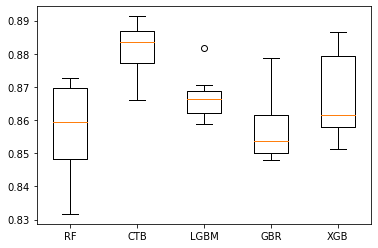

In [33]:
plt.boxplot(results_cv, labels=models.keys())
plt.show()

    The same results as for train test split

## Hyperparameters tuning with optuna

## CatBoost Regressor hyperparameters tuning

In [51]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0
    }

    model = CatBoostRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

In [55]:
study = optuna.create_study(direction='minimize')

[I 2023-08-17 19:41:45,727] A new study created in memory with name: no-name-295ebb1d-6c20-4e13-9c05-62f3de1a1a69


In [56]:
study.optimize(objective, n_trials=100)

C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'random_stre

[I 2023-08-17 19:42:30,408] Trial 4 finished with value: 79740.27327679556 and parameters: {'iterations': 563, 'depth': 4, 'learning_rate': 0.0334695420211111, 'l2_leaf_reg': 0.0827243368198728, 'random_strength': 0.27667105454189533, 'bagging_temperature': 0.1752866111361255, 'border_count': 91}. Best is trial 3 with value: 74694.06775998244.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg': tr

[I 2023-08-17 19:43:15,030] Trial 9 finished with value: 74740.08038527866 and parameters: {'iterations': 734, 'depth': 10, 'learning_rate': 0.026925884206741284, 'l2_leaf_reg': 0.09748460962902493, 'random_strength': 0.08950460219229704, 'bagging_temperature': 3.9445864328627116, 'border_count': 140}. Best is trial 3 with value: 74694.06775998244.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg

[I 2023-08-17 19:43:50,629] Trial 14 finished with value: 75247.17022941871 and parameters: {'iterations': 868, 'depth': 8, 'learning_rate': 0.16916643138101092, 'l2_leaf_reg': 0.005004630983426177, 'random_strength': 0.0045694901178499, 'bagging_temperature': 1.9476743729270107, 'border_count': 172}. Best is trial 11 with value: 73350.78604643278.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg

[I 2023-08-17 19:44:17,074] Trial 19 finished with value: 74209.42302129976 and parameters: {'iterations': 901, 'depth': 6, 'learning_rate': 0.053485530205477506, 'l2_leaf_reg': 0.019273458831804972, 'random_strength': 0.0027967430485108646, 'bagging_temperature': 1.1437347002984233, 'border_count': 167}. Best is trial 11 with value: 73350.78604643278.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf

[I 2023-08-17 19:44:53,417] Trial 24 finished with value: 74574.24879941953 and parameters: {'iterations': 880, 'depth': 8, 'learning_rate': 0.07048769735882784, 'l2_leaf_reg': 0.008159936105068691, 'random_strength': 0.0010224677312291926, 'bagging_temperature': 0.9294615323635815, 'border_count': 173}. Best is trial 21 with value: 73342.67679156453.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_

[I 2023-08-17 19:45:18,590] Trial 29 finished with value: 76270.07011792458 and parameters: {'iterations': 450, 'depth': 7, 'learning_rate': 0.08263711839627448, 'l2_leaf_reg': 0.0328976718717232, 'random_strength': 0.00183879250806889, 'bagging_temperature': 0.6113027183945485, 'border_count': 43}. Best is trial 21 with value: 73342.67679156453.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg':

[I 2023-08-17 19:45:57,566] Trial 34 finished with value: 74045.6781872914 and parameters: {'iterations': 939, 'depth': 8, 'learning_rate': 0.04472796820288762, 'l2_leaf_reg': 0.007755152952187123, 'random_strength': 0.0020491888389691194, 'bagging_temperature': 2.1623537183077315, 'border_count': 163}. Best is trial 21 with value: 73342.67679156453.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_r

[I 2023-08-17 19:46:54,109] Trial 39 finished with value: 74811.15335888308 and parameters: {'iterations': 880, 'depth': 10, 'learning_rate': 0.09625102082337321, 'l2_leaf_reg': 0.011257148006776733, 'random_strength': 0.001652416350445737, 'bagging_temperature': 5.0792164691142805, 'border_count': 114}. Best is trial 21 with value: 73342.67679156453.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_

[I 2023-08-17 19:47:16,051] Trial 44 finished with value: 74586.256640512 and parameters: {'iterations': 964, 'depth': 6, 'learning_rate': 0.11198820212864474, 'l2_leaf_reg': 0.0015952190437997869, 'random_strength': 0.0036195309857130157, 'bagging_temperature': 2.2209489495641943, 'border_count': 180}. Best is trial 21 with value: 73342.67679156453.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_r

[I 2023-08-17 19:47:53,959] Trial 49 finished with value: 74095.92711401971 and parameters: {'iterations': 965, 'depth': 9, 'learning_rate': 0.062486115234664456, 'l2_leaf_reg': 0.004224597639649532, 'random_strength': 0.002781659222457085, 'bagging_temperature': 1.875982810849153, 'border_count': 141}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_r

[I 2023-08-17 19:48:28,675] Trial 54 finished with value: 73559.70709521901 and parameters: {'iterations': 998, 'depth': 8, 'learning_rate': 0.07622819459511324, 'l2_leaf_reg': 0.003344306124142968, 'random_strength': 0.0014800990509644465, 'bagging_temperature': 1.3146157729822736, 'border_count': 151}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_

[I 2023-08-17 19:49:01,134] Trial 59 finished with value: 73708.77821048489 and parameters: {'iterations': 925, 'depth': 7, 'learning_rate': 0.07346510325496967, 'l2_leaf_reg': 0.006242292230057961, 'random_strength': 0.006066462908579157, 'bagging_temperature': 1.5888720383399595, 'border_count': 166}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_r

[I 2023-08-17 19:49:37,923] Trial 64 finished with value: 73949.657666331 and parameters: {'iterations': 953, 'depth': 8, 'learning_rate': 0.06933391421256754, 'l2_leaf_reg': 0.003324242454937137, 'random_strength': 0.0020334747675939614, 'bagging_temperature': 0.8769686377021387, 'border_count': 96}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg

[I 2023-08-17 19:50:19,750] Trial 69 finished with value: 74224.92774597344 and parameters: {'iterations': 740, 'depth': 10, 'learning_rate': 0.10608390416458464, 'l2_leaf_reg': 0.001238796351523261, 'random_strength': 0.0010003966314904693, 'bagging_temperature': 0.8424381509408189, 'border_count': 108}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf

[I 2023-08-17 19:50:52,504] Trial 74 finished with value: 73330.98729890818 and parameters: {'iterations': 911, 'depth': 7, 'learning_rate': 0.12044252582758723, 'l2_leaf_reg': 0.001915689497901515, 'random_strength': 0.0020711120269369405, 'bagging_temperature': 0.7005030414340211, 'border_count': 161}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_

[I 2023-08-17 19:51:22,465] Trial 79 finished with value: 73284.1483231358 and parameters: {'iterations': 905, 'depth': 6, 'learning_rate': 0.08679420656924841, 'l2_leaf_reg': 0.0022821191585081168, 'random_strength': 0.0024006123407477654, 'bagging_temperature': 0.5126539742747976, 'border_count': 149}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_

[I 2023-08-17 19:51:50,186] Trial 84 finished with value: 73627.39824786599 and parameters: {'iterations': 869, 'depth': 7, 'learning_rate': 0.06491145490039334, 'l2_leaf_reg': 0.0010084706564237515, 'random_strength': 0.0028519091837520306, 'bagging_temperature': 0.691124868952867, 'border_count': 153}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_

[I 2023-08-17 19:52:17,994] Trial 89 finished with value: 73746.80867090654 and parameters: {'iterations': 906, 'depth': 7, 'learning_rate': 0.06049192640865934, 'l2_leaf_reg': 0.0013640835952537461, 'random_strength': 0.007554589992023007, 'bagging_temperature': 0.4893170211390336, 'border_count': 156}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_

[I 2023-08-17 19:53:01,338] Trial 94 finished with value: 74617.72488741604 and parameters: {'iterations': 920, 'depth': 8, 'learning_rate': 0.09817118447553462, 'l2_leaf_reg': 0.0049240976335243394, 'random_strength': 0.0033962974173166287, 'bagging_temperature': 0.7900369614487868, 'border_count': 133}. Best is trial 48 with value: 72796.02244675995.
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_20244\710089640.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf

[I 2023-08-17 19:53:29,333] Trial 99 finished with value: 73225.28490173766 and parameters: {'iterations': 883, 'depth': 7, 'learning_rate': 0.08261540145983558, 'l2_leaf_reg': 0.001603253231096463, 'random_strength': 0.0026671143130924334, 'bagging_temperature': 1.0548877070877967, 'border_count': 110}. Best is trial 48 with value: 72796.02244675995.


In [57]:
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: {}'.format(trial.value))
print('Params: ')
for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
Value: 72796.02244675995
Params: 
iterations: 961
depth: 8
learning_rate: 0.059988364506737814
l2_leaf_reg: 0.004272462604289636
random_strength: 0.0029533465574436
bagging_temperature: 1.7180720593286907
border_count: 145


In [58]:
best_trial = study.best_trial

best_params = best_trial.params

best_model = CatBoostRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

0:	learn: 344981.6314999	total: 5.29ms	remaining: 5.08s
1:	learn: 329770.3120139	total: 10.8ms	remaining: 5.17s
2:	learn: 315450.3166629	total: 15.6ms	remaining: 4.99s
3:	learn: 302253.7887289	total: 20.7ms	remaining: 4.96s
4:	learn: 289724.0011937	total: 25.6ms	remaining: 4.89s
5:	learn: 278066.3575334	total: 30.6ms	remaining: 4.87s
6:	learn: 267126.4532000	total: 35.3ms	remaining: 4.81s
7:	learn: 256941.1045867	total: 40.4ms	remaining: 4.81s
8:	learn: 247259.7691039	total: 45.8ms	remaining: 4.84s
9:	learn: 238370.2483098	total: 50.8ms	remaining: 4.83s
10:	learn: 229950.7851599	total: 55.7ms	remaining: 4.81s
11:	learn: 222106.9221257	total: 62.5ms	remaining: 4.94s
12:	learn: 214899.1755985	total: 69ms	remaining: 5.03s
13:	learn: 208140.4409232	total: 75.5ms	remaining: 5.11s
14:	learn: 201682.1552770	total: 82.5ms	remaining: 5.2s
15:	learn: 195802.4774279	total: 87.9ms	remaining: 5.19s
16:	learn: 190300.2635909	total: 95.7ms	remaining: 5.31s
17:	learn: 185127.5583225	total: 104ms	remai

176:	learn: 91215.4082836	total: 900ms	remaining: 3.99s
177:	learn: 91066.2034220	total: 906ms	remaining: 3.98s
178:	learn: 90976.2352419	total: 911ms	remaining: 3.98s
179:	learn: 90848.5426688	total: 916ms	remaining: 3.98s
180:	learn: 90669.3968598	total: 921ms	remaining: 3.97s
181:	learn: 90536.2283085	total: 925ms	remaining: 3.96s
182:	learn: 90363.7628894	total: 930ms	remaining: 3.95s
183:	learn: 90247.9977860	total: 935ms	remaining: 3.95s
184:	learn: 90141.5679222	total: 939ms	remaining: 3.94s
185:	learn: 90043.2346138	total: 944ms	remaining: 3.93s
186:	learn: 89936.2876120	total: 949ms	remaining: 3.93s
187:	learn: 89818.6975508	total: 953ms	remaining: 3.92s
188:	learn: 89620.2280999	total: 958ms	remaining: 3.91s
189:	learn: 89402.0539816	total: 962ms	remaining: 3.9s
190:	learn: 89263.4970461	total: 966ms	remaining: 3.89s
191:	learn: 89125.8000887	total: 970ms	remaining: 3.88s
192:	learn: 89020.1014333	total: 975ms	remaining: 3.88s
193:	learn: 88921.0146627	total: 980ms	remaining:

325:	learn: 76644.7172791	total: 1.61s	remaining: 3.14s
326:	learn: 76573.2393013	total: 1.62s	remaining: 3.14s
327:	learn: 76492.2554402	total: 1.62s	remaining: 3.13s
328:	learn: 76374.1293888	total: 1.63s	remaining: 3.13s
329:	learn: 76275.8302532	total: 1.63s	remaining: 3.12s
330:	learn: 76198.6451464	total: 1.64s	remaining: 3.12s
331:	learn: 76158.1258545	total: 1.64s	remaining: 3.11s
332:	learn: 76087.2757804	total: 1.65s	remaining: 3.11s
333:	learn: 76045.4292222	total: 1.65s	remaining: 3.1s
334:	learn: 75997.8018594	total: 1.66s	remaining: 3.1s
335:	learn: 75950.7707453	total: 1.66s	remaining: 3.09s
336:	learn: 75905.9321947	total: 1.67s	remaining: 3.09s
337:	learn: 75870.3609498	total: 1.67s	remaining: 3.08s
338:	learn: 75810.0184663	total: 1.68s	remaining: 3.08s
339:	learn: 75757.4938153	total: 1.68s	remaining: 3.07s
340:	learn: 75682.4095445	total: 1.69s	remaining: 3.07s
341:	learn: 75613.5849211	total: 1.69s	remaining: 3.06s
342:	learn: 75560.2071226	total: 1.7s	remaining: 3

472:	learn: 68416.7290395	total: 2.33s	remaining: 2.4s
473:	learn: 68366.6182022	total: 2.33s	remaining: 2.4s
474:	learn: 68301.2959166	total: 2.34s	remaining: 2.39s
475:	learn: 68255.2463467	total: 2.34s	remaining: 2.39s
476:	learn: 68229.1927277	total: 2.35s	remaining: 2.38s
477:	learn: 68203.6925585	total: 2.35s	remaining: 2.38s
478:	learn: 68153.2203181	total: 2.36s	remaining: 2.37s
479:	learn: 68091.5481102	total: 2.36s	remaining: 2.37s
480:	learn: 68068.3771858	total: 2.37s	remaining: 2.36s
481:	learn: 68032.7905528	total: 2.37s	remaining: 2.35s
482:	learn: 67992.5609298	total: 2.38s	remaining: 2.35s
483:	learn: 67938.3330369	total: 2.38s	remaining: 2.35s
484:	learn: 67876.8090461	total: 2.38s	remaining: 2.34s
485:	learn: 67834.0528891	total: 2.39s	remaining: 2.33s
486:	learn: 67763.5046688	total: 2.39s	remaining: 2.33s
487:	learn: 67696.3671056	total: 2.4s	remaining: 2.32s
488:	learn: 67662.4091347	total: 2.4s	remaining: 2.32s
489:	learn: 67589.7871776	total: 2.41s	remaining: 2.

653:	learn: 61496.3212215	total: 3.22s	remaining: 1.51s
654:	learn: 61467.0460633	total: 3.23s	remaining: 1.51s
655:	learn: 61431.1195046	total: 3.23s	remaining: 1.5s
656:	learn: 61371.0863041	total: 3.24s	remaining: 1.5s
657:	learn: 61348.5220730	total: 3.24s	remaining: 1.49s
658:	learn: 61300.1007082	total: 3.25s	remaining: 1.49s
659:	learn: 61241.2026171	total: 3.25s	remaining: 1.48s
660:	learn: 61189.7758405	total: 3.26s	remaining: 1.48s
661:	learn: 61146.1093629	total: 3.26s	remaining: 1.47s
662:	learn: 61123.4895633	total: 3.27s	remaining: 1.47s
663:	learn: 61092.2840366	total: 3.27s	remaining: 1.46s
664:	learn: 61056.6296523	total: 3.28s	remaining: 1.46s
665:	learn: 61018.7020915	total: 3.28s	remaining: 1.45s
666:	learn: 60959.1869988	total: 3.29s	remaining: 1.45s
667:	learn: 60935.7241412	total: 3.29s	remaining: 1.44s
668:	learn: 60918.5790124	total: 3.29s	remaining: 1.44s
669:	learn: 60878.2531017	total: 3.3s	remaining: 1.43s
670:	learn: 60854.0614539	total: 3.3s	remaining: 1.

809:	learn: 56732.2165603	total: 4.11s	remaining: 766ms
810:	learn: 56708.4953511	total: 4.12s	remaining: 761ms
811:	learn: 56687.9277923	total: 4.12s	remaining: 756ms
812:	learn: 56659.0532665	total: 4.13s	remaining: 751ms
813:	learn: 56635.6849830	total: 4.13s	remaining: 746ms
814:	learn: 56618.1548095	total: 4.13s	remaining: 741ms
815:	learn: 56571.2341585	total: 4.14s	remaining: 736ms
816:	learn: 56559.1380161	total: 4.14s	remaining: 730ms
817:	learn: 56524.9087083	total: 4.15s	remaining: 725ms
818:	learn: 56498.8172079	total: 4.15s	remaining: 720ms
819:	learn: 56483.4250943	total: 4.16s	remaining: 715ms
820:	learn: 56467.1572106	total: 4.16s	remaining: 710ms
821:	learn: 56442.7819054	total: 4.17s	remaining: 705ms
822:	learn: 56426.4837321	total: 4.17s	remaining: 699ms
823:	learn: 56404.8212152	total: 4.18s	remaining: 694ms
824:	learn: 56373.3541291	total: 4.18s	remaining: 689ms
825:	learn: 56344.0909668	total: 4.18s	remaining: 684ms
826:	learn: 56317.5317807	total: 4.19s	remaining

In [59]:
print('Best Trial:')
print('Train R2 Score:', train_r2)
print('Test R2 Score:', test_r2)

Best Trial:
Train R2 Score: 0.9783427711557453
Test R2 Score: 0.8735399487331149


# Conclusions

   Five machine learning models based on decision trees were checked.
   
   After dividing the dataset into train and test set best results gives CatBoostRegressor.
   
   Crossvalidation of whole dataset gives best r2_scores also was for CatBoostRegressor.
   
   After hyperparameters tuning with optuna: r2_scores were corrected to 97,8% for training set and for 87,3% for test set (mean_absolute_error was reduced from ~75000 to ~72800)